In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import warnings
import seaborn as sns
from sklearn.metrics import mean_absolute_error

### Data Prep

In [ ]:
# DON'T NEED TO RE-RUN, THIS CODE WAS TO GET THE FILTERED DATA WITH ONLY THOSE PRODUCTS THAT HAVE DATA FOR >=25 MONTHS

df = pd.read_csv("descriptions_month_filtered.csv")

df_filtered = df[df["unique_invoice_months"] >= 25]

df_filtered.to_csv("descriptions_month_filtered_25.csv", index=False)

In [ ]:
good_products = pd.read_csv("descriptions_month_filtered_25.csv")
display(good_products)

,description,earliest_invoicedate,latest_invoicedate,unique_invoice_months,sum_quantity
0,12 EGG HOUSE PAINTED WOOD,2009-12-01 11:41:00,2011-12-08 15:54:00,25,563
1,12 PENCILS SMALL TUBE SKULL,2009-12-01 12:47:00,2011-12-09 12:20:00,25,12899
2,12 PENCILS TALL TUBE SKULLS,2009-12-01 11:37:00,2011-12-09 10:03:00,25,4899
3,12 PENCILS TALL TUBE WOODLAND,2009-12-01 12:47:00,2011-12-09 08:59:00,25,4703
4,12 RED ROSE PEG PLACE SETTINGS,2009-12-03 16:54:00,2011-12-08 19:28:00,25,1277
...,...,...,...,...,...
543,WOVEN ROSE GARDEN CUSHION COVER,2009-12-03 13:32:00,2011-12-09 10:03:00,25,494
544,WRAP PINK FAIRY CAKES,2009-12-01 18:35:00,2011-12-08 12:29:00,25,16615
545,ZINC HEART LATTICE T-LIGHT HOLDER,2009-12-14 18:03:00,2011-12-07 09:22:00,25,1471
546,ZINC METAL HEART DECORATION,2009-12-01 11:41:00,2011-12-08 14:38:00,25,20149


In [ ]:
# DON'T RUN AGAIN, THIS IS ONLY TO GET FINAL DATA NEEDED FOR THE MODELS

file_path = 'online_retail_II.xlsx'
xls = pd.ExcelFile(file_path)
df1 = pd.read_excel(xls, sheet_name=xls.sheet_names[0])
df2 = pd.read_excel(xls, sheet_name=xls.sheet_names[1])
retail_df = pd.concat([df1, df2], ignore_index=True)

df_desc_na = retail_df[retail_df['Description'].notna()]

REMOVE = ["Discount", "Manual"]
df_remove = df_desc_na[~df_desc_na['Description'].isin(REMOVE)]

df_no_price = df_remove[df_remove['Price'] > 0]

filtered_df = df_no_price

filtered_df['InvoiceDate'] = pd.to_datetime(filtered_df['InvoiceDate'])

<ipython-input-5-7eb6ae0ffe6b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['InvoiceDate'] = pd.to_datetime(filtered_df['InvoiceDate'])


In [ ]:
display(filtered_df)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
filtered_df = filtered_df[filtered_df["Description"].isin(good_products["description"])]

In [ ]:
display(filtered_df)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
13,489436,21755,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.45,13078.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067344,581585,84692,BOX OF 24 COCKTAIL PARASOLS,25,2011-12-09 12:31:00,0.42,15804.0,United Kingdom
1067346,581585,21684,SMALL MEDINA STAMPED METAL BOWL,12,2011-12-09 12:31:00,0.85,15804.0,United Kingdom
1067351,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
filtered_df.to_csv("Data_without_cluster_index_info.csv", index=False)

In [ ]:
# DON'T RE-RUN, THIS IS TO GET THE DATASET WHICH INCLUDES THE INDEX VALUES FOR BOTH CPI AND S&P

data_path = "Data_without_cluster_index_info.csv"
sp500_path = "S&P 500 Monthly Close.csv"
uk_cpi_path = "UK_CPI.csv"

data_df = pd.read_csv(data_path)
sp500_df = pd.read_csv(sp500_path)
uk_cpi_df = pd.read_csv(uk_cpi_path)

data_df.head(), sp500_df.head(), uk_cpi_df.head()

data_df["InvoiceDate"] = pd.to_datetime(data_df["InvoiceDate"])
data_df["YearMonth"] = data_df["InvoiceDate"].dt.strftime("%Y-%m")

sp500_df["YearMonth"] = pd.to_datetime(sp500_df["Month"], format="%m/%Y").dt.strftime("%Y-%m")

uk_cpi_df["Date"] = pd.to_datetime(uk_cpi_df["Date"])
uk_cpi_df["YearMonth"] = uk_cpi_df["Date"].dt.strftime("%Y-%m")

merged_df = data_df.merge(sp500_df[["YearMonth", "SP500_Close"]], on="YearMonth", how="left")

merged_df = merged_df.merge(uk_cpi_df[["YearMonth", "CPI"]], on="YearMonth", how="left")

display(merged_df)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,YearMonth,SP500_Close,CPI
0,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12,"1,115.10",2.51
1,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12,"1,115.10",2.51
2,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,2009-12,"1,115.10",2.51
3,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12,"1,115.10",2.51
4,489436,21755,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.45,13078.0,United Kingdom,2009-12,"1,115.10",2.51
...,...,...,...,...,...,...,...,...,...,...,...
303542,581585,84692,BOX OF 24 COCKTAIL PARASOLS,25,2011-12-09 12:31:00,0.42,15804.0,United Kingdom,2011-12,"1,257.60",3.69
303543,581585,21684,SMALL MEDINA STAMPED METAL BOWL,12,2011-12-09 12:31:00,0.85,15804.0,United Kingdom,2011-12,"1,257.60",3.69
303544,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,2011-12,"1,257.60",3.69
303545,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12,"1,257.60",3.69


In [ ]:
merged_df.to_csv("Data_with_indices_no_cluster.csv", index=False)

In [ ]:
# DON'T RE-RUN, THIS IS TO GET THE FINAL DATAFRAME WITH ALL FILTERS, CLUSTER DATA, AND ADDITIONAL INDEX DATA

data_path = "Data_with_indices_no_cluster.csv"
cluster_path = "data_based_clusters.csv"
group_path = "desc_25_11groups.csv"

data_df = pd.read_csv(data_path)
cluster_df = pd.read_csv(cluster_path)
group_df = pd.read_csv(group_path)

cluster_df.rename(columns={'description': 'Description'}, inplace=True)

data_df = data_df.merge(cluster_df[['Description', 'cluster']], on='Description', how='left')

data_df = data_df.merge(group_df[['Description', 'Group']], on='Description', how='left')

data_df.rename(columns={'cluster': 'data_based_cluster'}, inplace=True)
data_df.rename(columns={'Group': 'desc_based_cluster'}, inplace=True)

display(data_df)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,YearMonth,SP500_Close,CPI,data_based_cluster,desc_based_cluster
0,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12,"1,115.10",2.51,3,1
1,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12,"1,115.10",2.51,1,6
2,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,2009-12,"1,115.10",2.51,2,6
3,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12,"1,115.10",2.51,8,2
4,489436,21755,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.45,13078.0,United Kingdom,2009-12,"1,115.10",2.51,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
303542,581585,84692,BOX OF 24 COCKTAIL PARASOLS,25,2011-12-09 12:31:00,0.42,15804.0,United Kingdom,2011-12,"1,257.60",3.69,8,5
303543,581585,21684,SMALL MEDINA STAMPED METAL BOWL,12,2011-12-09 12:31:00,0.85,15804.0,United Kingdom,2011-12,"1,257.60",3.69,7,1
303544,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,2011-12,"1,257.60",3.69,4,2
303545,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12,"1,257.60",3.69,3,5


In [ ]:
data_df.to_csv("FINAL_DATA.csv", index=False)

## SARIMA, description based clustering

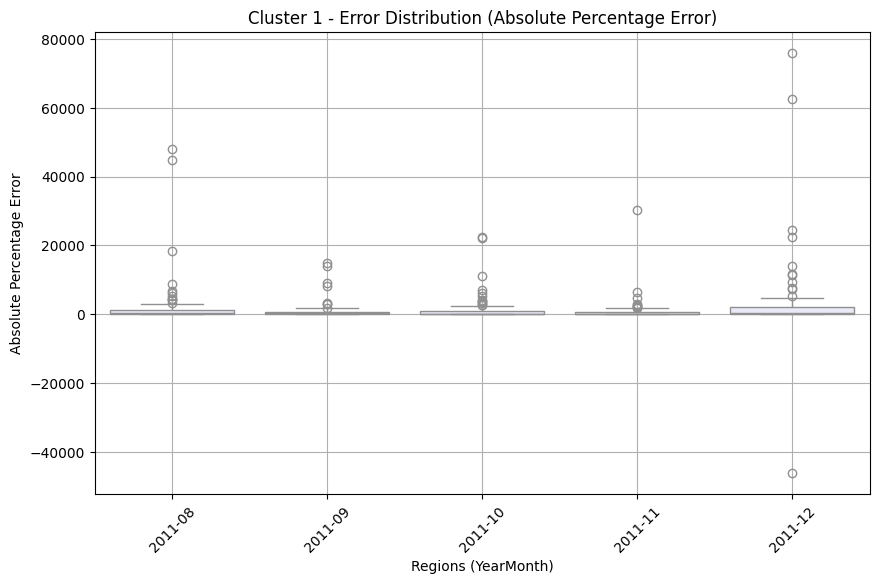

Cluster 1: MAPE Scores for each region:
  Region 2011-08: MAPE = 23.0596%
  Region 2011-09: MAPE = 10.3401%
  Region 2011-10: MAPE = 14.6641%
  Region 2011-11: MAPE = 9.5522%
  Region 2011-12: MAPE = 44.4674%


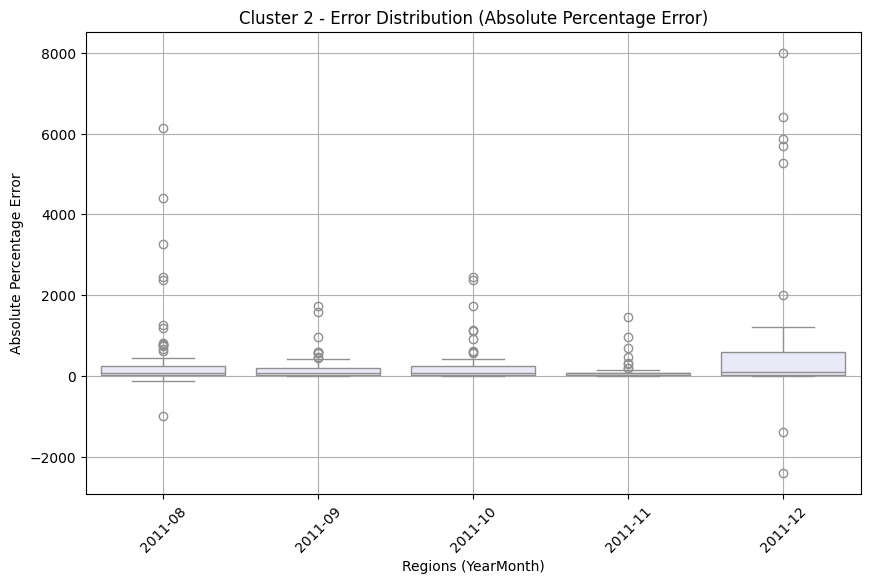

Cluster 2: MAPE Scores for each region:
  Region 2011-08: MAPE = 4.3512%
  Region 2011-09: MAPE = 1.8029%
  Region 2011-10: MAPE = 2.3446%
  Region 2011-11: MAPE = 1.1668%
  Region 2011-12: MAPE = 7.2565%


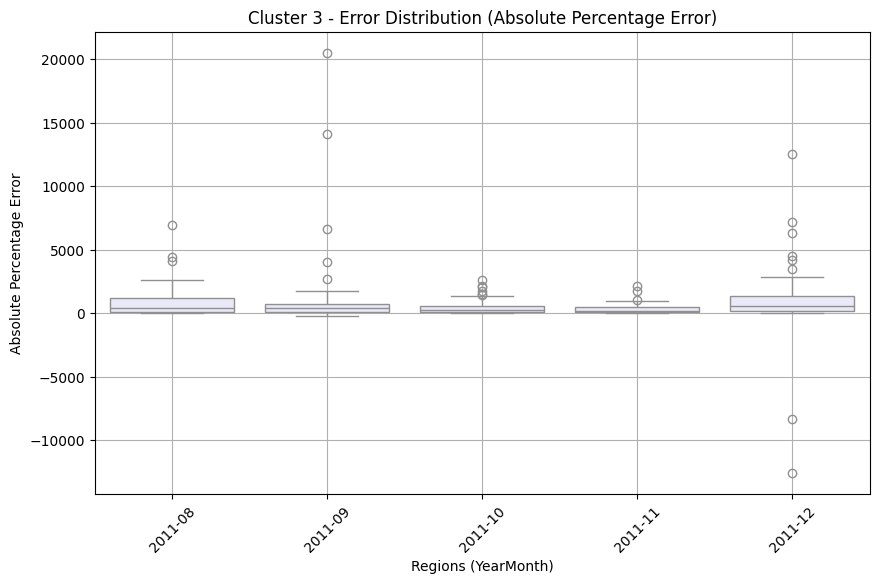

Cluster 3: MAPE Scores for each region:
  Region 2011-08: MAPE = 9.1269%
  Region 2011-09: MAPE = 12.6823%
  Region 2011-10: MAPE = 4.8038%
  Region 2011-11: MAPE = 3.3219%
  Region 2011-12: MAPE = 16.7024%


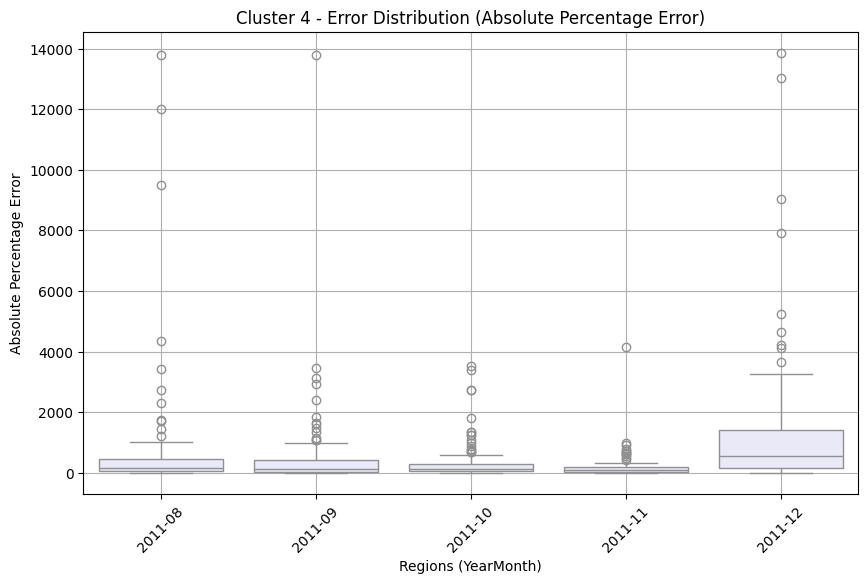

Cluster 4: MAPE Scores for each region:
  Region 2011-08: MAPE = 7.5027%
  Region 2011-09: MAPE = 5.2895%
  Region 2011-10: MAPE = 3.5769%
  Region 2011-11: MAPE = 1.9838%
  Region 2011-12: MAPE = 13.6111%


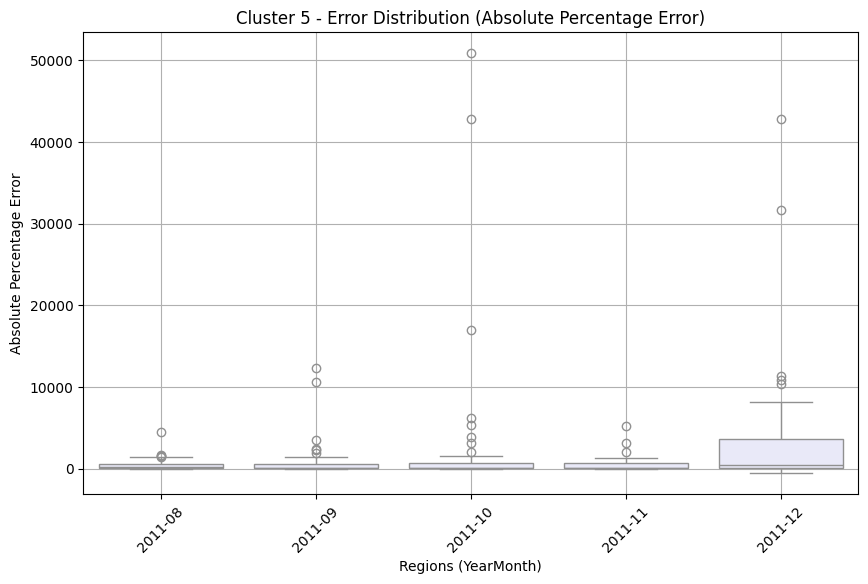

Cluster 5: MAPE Scores for each region:
  Region 2011-08: MAPE = 4.4887%
  Region 2011-09: MAPE = 8.3736%
  Region 2011-10: MAPE = 26.5442%
  Region 2011-11: MAPE = 4.7562%
  Region 2011-12: MAPE = 32.8557%


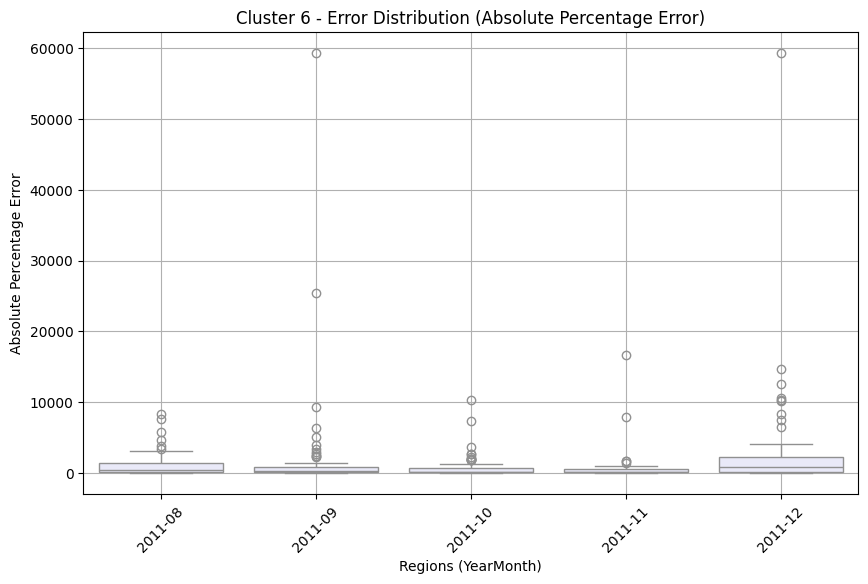

Cluster 6: MAPE Scores for each region:
  Region 2011-08: MAPE = 10.9092%
  Region 2011-09: MAPE = 21.5569%
  Region 2011-10: MAPE = 7.8753%
  Region 2011-11: MAPE = 6.8912%
  Region 2011-12: MAPE = 29.4764%


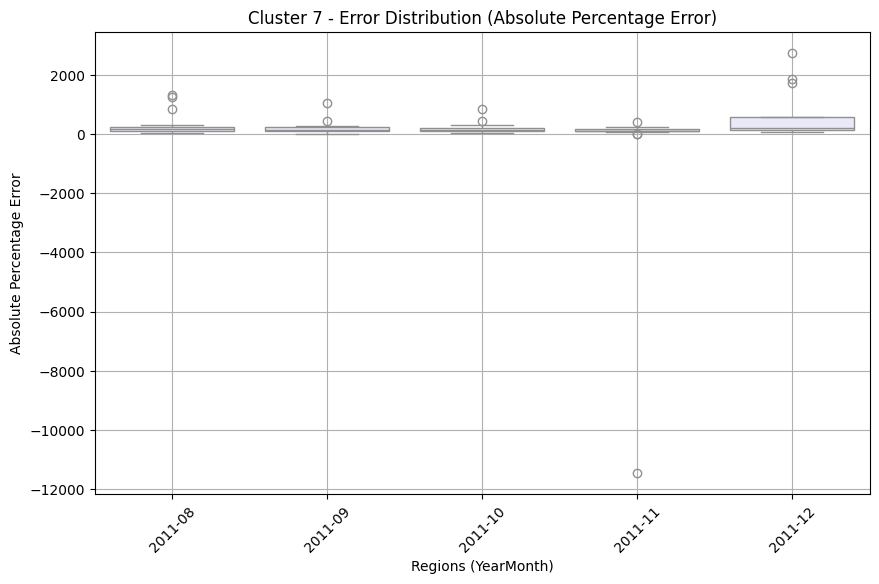

Cluster 7: MAPE Scores for each region:
  Region 2011-08: MAPE = 3.2123%
  Region 2011-09: MAPE = 2.0629%
  Region 2011-10: MAPE = 1.8543%
  Region 2011-11: MAPE = 7.6620%
  Region 2011-12: MAPE = 5.5457%


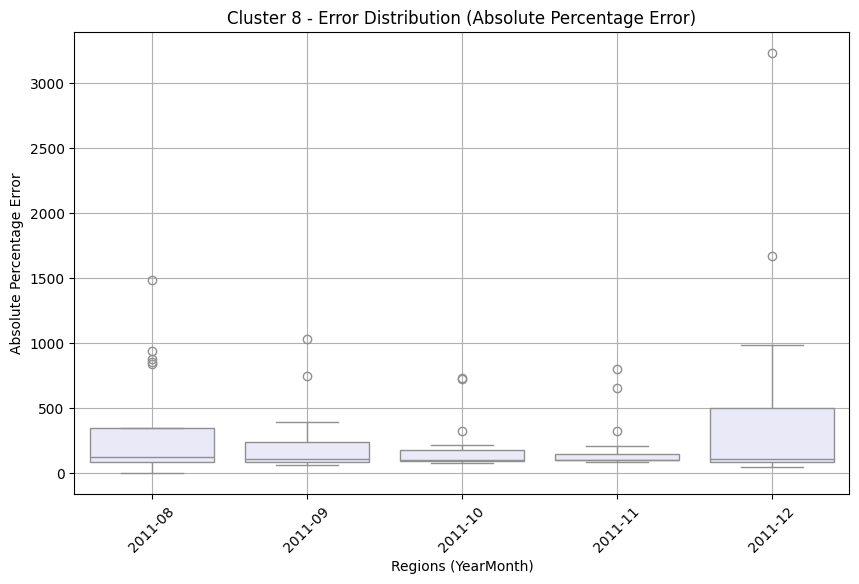

Cluster 8: MAPE Scores for each region:
  Region 2011-08: MAPE = 3.3620%
  Region 2011-09: MAPE = 2.2052%
  Region 2011-10: MAPE = 1.8358%
  Region 2011-11: MAPE = 1.8126%
  Region 2011-12: MAPE = 4.5626%


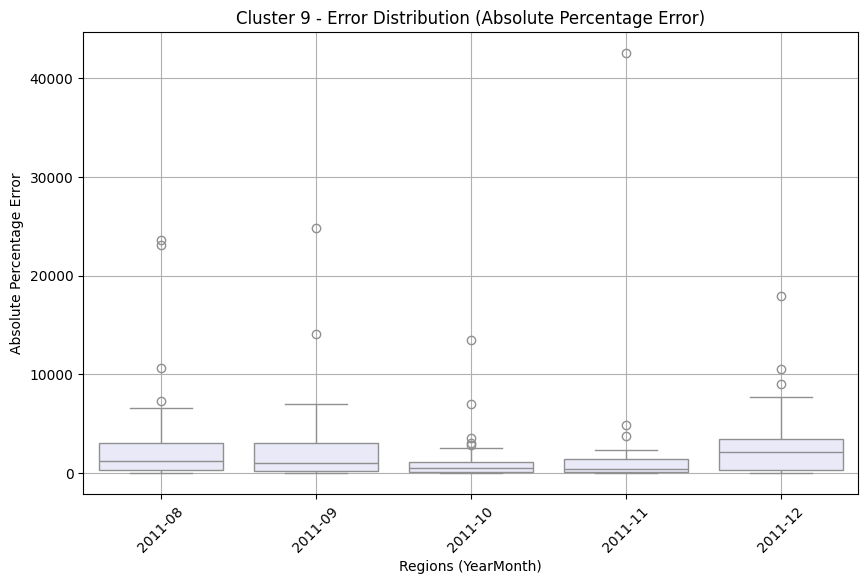

Cluster 9: MAPE Scores for each region:
  Region 2011-08: MAPE = 30.3474%
  Region 2011-09: MAPE = 25.5411%
  Region 2011-10: MAPE = 12.7613%
  Region 2011-11: MAPE = 18.6899%
  Region 2011-12: MAPE = 28.5898%


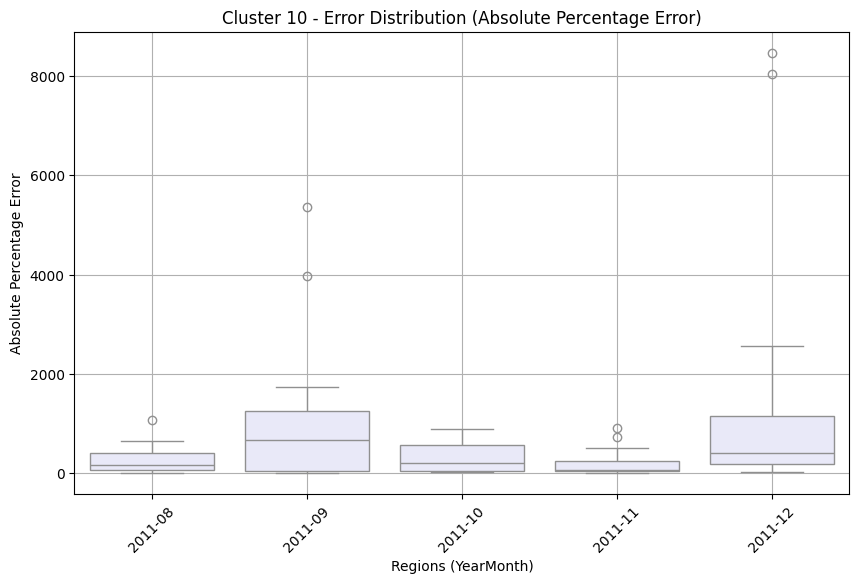

Cluster 10: MAPE Scores for each region:
  Region 2011-08: MAPE = 2.6022%
  Region 2011-09: MAPE = 10.6222%
  Region 2011-10: MAPE = 3.2870%
  Region 2011-11: MAPE = 2.0988%
  Region 2011-12: MAPE = 16.1131%


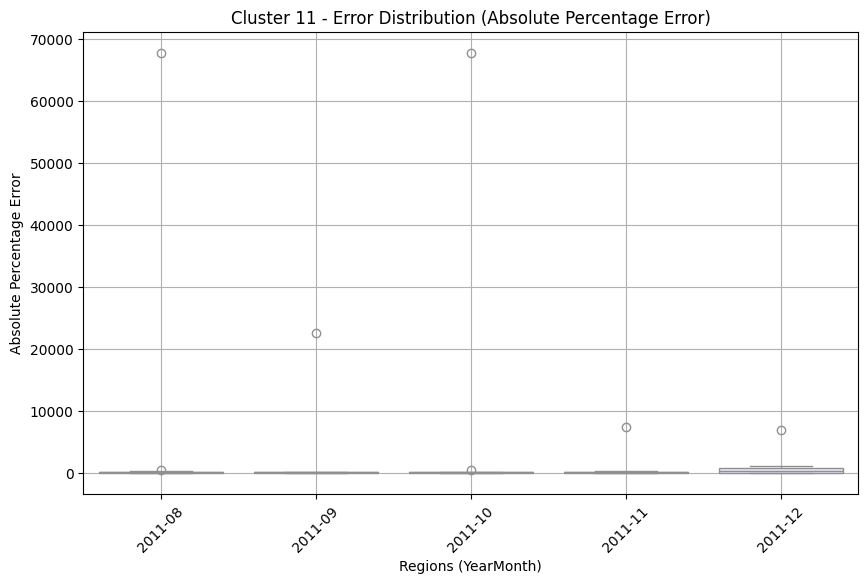

Cluster 11: MAPE Scores for each region:
  Region 2011-08: MAPE = 69.1285%
  Region 2011-09: MAPE = 23.3346%
  Region 2011-10: MAPE = 68.8630%
  Region 2011-11: MAPE = 8.3930%
  Region 2011-12: MAPE = 10.3868%

Overall MAPE Scores for each region (Across all clusters):
  Region 2011-08: MAPE = 15.2810%
  Region 2011-09: MAPE = 11.2556%
  Region 2011-10: MAPE = 13.4918%
  Region 2011-11: MAPE = 6.0298%
  Region 2011-12: MAPE = 19.0516%


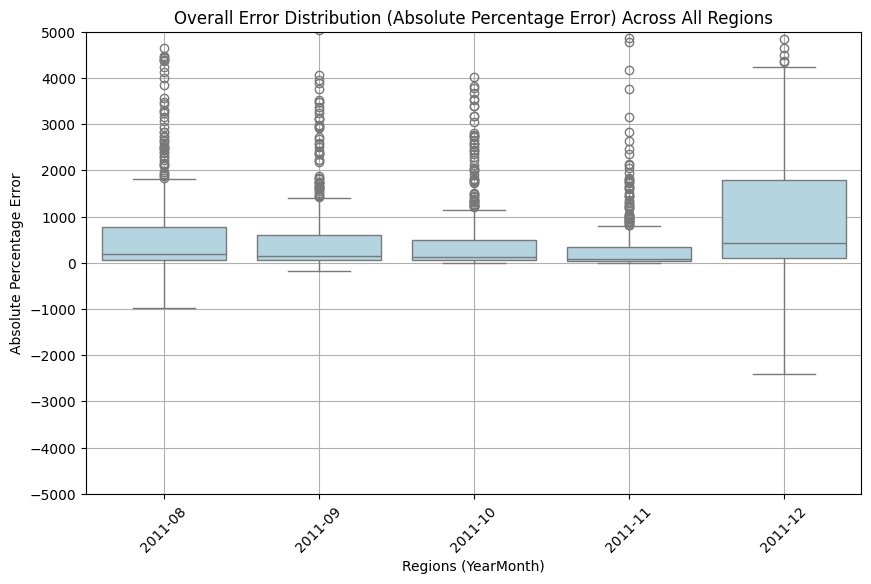

In [41]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.simplefilter(action='ignore', category=UserWarning)

# Load and preprocess data
data = pd.read_csv("FINAL_DATA.csv", parse_dates=["InvoiceDate"])
data.sort_values(by=["desc_based_cluster", "InvoiceDate"], inplace=True)
data["total_sales"] = data["Quantity"] * data["Price"]

clusters = data["desc_based_cluster"].unique()
cluster_dataframes = {cluster: data[data["desc_based_cluster"] == cluster].copy() for cluster in clusters}

# Initialize dictionaries to store MAPE scores, models, predictions, and errors
mape_scores = {}
models = {}
all_preds = {}
all_errors = {}

# Overall MAPE for regions
overall_mape_scores = {region: [] for region in data["YearMonth"].unique()}

for cluster, cluster_data in cluster_dataframes.items():
    unique_descriptions = cluster_data["Description"].unique()
    desc = unique_descriptions[0]
    months_to_loop = cluster_data['YearMonth'].unique()

    total_data = cluster_data[(data["Description"] != desc)]
    one_product = cluster_data[(data["Description"] == desc)]

    total_data = total_data.sort_values(by="InvoiceDate")
    one_product = one_product.sort_values(by="InvoiceDate")

    # Train-test split (80% training, last 5 months for testing)
    train_data = total_data[total_data['YearMonth'].isin(months_to_loop[:20])]
    train_data_aggregated = train_data.groupby(['YearMonth', 'Description'])['total_sales'].sum().reset_index()

    test_data = total_data[total_data['YearMonth'].isin(months_to_loop[20:])]
    test_data_aggregated = test_data.groupby(['YearMonth', 'Description'])['total_sales'].sum().reset_index()

    try:
        model = SARIMAX(train_data_aggregated['total_sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)

    except Exception as e:
        print(f"Error in model for cluster {cluster}, Description {desc}: {e}")
        continue

    # Get unique YearMonth values for testing regions
    regions = test_data_aggregated['YearMonth'].unique()

    region_errors = {}  # Dictionary to store per-region error lists
    predictions = []

    # Initialize MAPE scores storage
    mape_scores[cluster] = {}

    for region in regions:
        region_data = test_data_aggregated[test_data_aggregated['YearMonth'] == region].copy()

        # Forecast for this region
        try:
            forecast_steps = len(region_data)
            preds = model_fit.forecast(steps=forecast_steps)

            # Store predictions in the DataFrame
            region_data["predicted_sales"] = preds.values

            # Compute individual absolute percentage errors
            region_data["absolute_percentage_error"] = (
                abs(region_data["total_sales"] - region_data["predicted_sales"]) / region_data["total_sales"]
            ) * 100

            # Store list of errors per region for boxplot visualization
            region_errors[region] = region_data["absolute_percentage_error"].tolist()

            mape = mean_absolute_percentage_error(region_data["total_sales"], region_data["predicted_sales"])

            # Store MAPE in the dictionary for this cluster and region
            mape_scores[cluster][region] = mape

            # Store predictions
            predictions.append(preds)

            # Store the errors for overall MAPE
            overall_mape_scores[region].extend(region_errors[region])

        except Exception as e:
            print(f"Error during forecasting for cluster {cluster}, Region {region}: {e}")
            continue

    # Convert region errors to a DataFrame for proper boxplot formatting
    error_data = []
    region_labels = []

    for region, errors in region_errors.items():
        for error in errors:  # Store multiple error values per region
            error_data.append(error)
            region_labels.append(region)

    error_df = pd.DataFrame({"Region": region_labels, "Absolute Percentage Error": error_data})

    # Plot the boxplot with regions correctly separated at the cluster level
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Region", y="Absolute Percentage Error", data=error_df, color='lavender')

    plt.xticks(rotation=45)
    plt.title(f"Cluster {cluster} - Error Distribution (Absolute Percentage Error)")
    plt.xlabel("Regions (YearMonth)")
    plt.ylabel("Absolute Percentage Error")
    plt.grid(True)
    plt.show()

    print(f"Cluster {cluster}: MAPE Scores for each region:")
    for region, mape in mape_scores[cluster].items():
        print(f"  Region {region}: MAPE = {mape:.4f}%")

# Now compute overall MAPE across all clusters for each region (without the cluster level)
overall_mape_scores_final = {}

# Remove keys with empty lists from the overall_mape_scores dictionary
overall_mape_scores = {region: errors for region, errors in overall_mape_scores.items() if errors}


# Calculate the overall MAPE for each region across all clusters
for cluster in mape_scores:
    for region, mape in mape_scores[cluster].items():
        if region not in overall_mape_scores_final:
            overall_mape_scores_final[region] = []
        overall_mape_scores_final[region].append(mape)

# Calculate the mean MAPE for each region across all clusters
for region, errors in overall_mape_scores_final.items():
    overall_mape_scores_final[region] = sum(errors) / len(errors)

# Print overall MAPE scores for each region
print("\nOverall MAPE Scores for each region (Across all clusters):")
for region, mape in overall_mape_scores_final.items():
    print(f"  Region {region}: MAPE = {mape:.4f}%")

# Plot the overall boxplots for each region across all clusters
overall_error_data = []
overall_region_labels = []

for region, errors in overall_mape_scores.items():
    for error in errors:  # Store multiple error values per region
        overall_error_data.append(error)
        overall_region_labels.append(region)

overall_error_df = pd.DataFrame({"Region": overall_region_labels, "Absolute Percentage Error": overall_error_data})

# Plot the boxplot for all regions combined (no cluster breakdown)
plt.figure(figsize=(10, 6))
sns.boxplot(x="Region", y="Absolute Percentage Error", data=overall_error_df, color='lightblue')

plt.xticks(rotation=45)
plt.title(f"Overall Error Distribution (Absolute Percentage Error) Across All Regions")
plt.xlabel("Regions (YearMonth)")
plt.ylabel("Absolute Percentage Error")
plt.grid(True)

# Set the y-axis limit to 40,000 and tick intervals to 10,000
plt.ylim(-5000, 5000)
plt.yticks(range(-5000, 5001, 1000))  # Labels at intervals of 10,000

plt.show()

## SARIMA, data based clustering

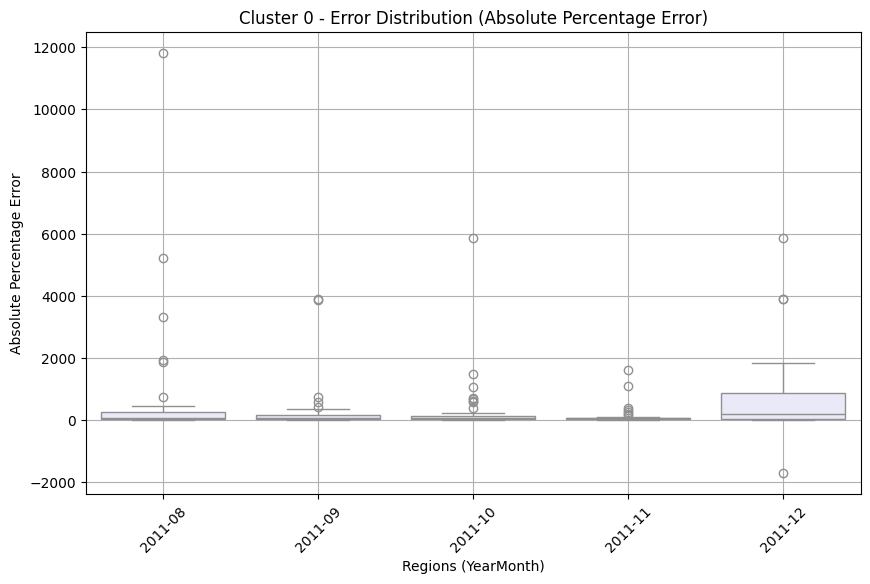

Cluster 0: MAPE Scores for each region:
  Region 2011-08: MAPE = 7.1449%
  Region 2011-09: MAPE = 3.1608%
  Region 2011-10: MAPE = 3.4230%
  Region 2011-11: MAPE = 1.4450%
  Region 2011-12: MAPE = 7.5283%


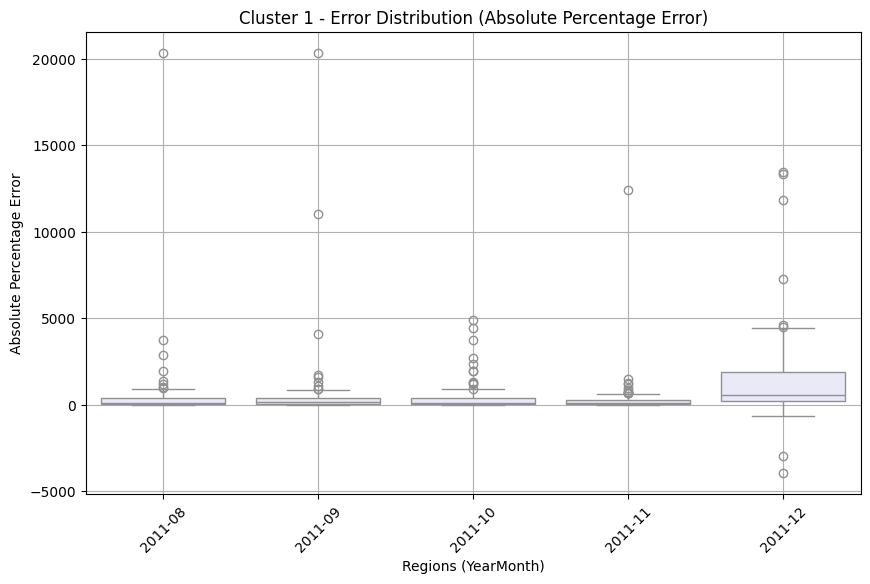

Cluster 1: MAPE Scores for each region:
  Region 2011-08: MAPE = 5.4543%
  Region 2011-09: MAPE = 6.4784%
  Region 2011-10: MAPE = 4.5076%
  Region 2011-11: MAPE = 3.5243%
  Region 2011-12: MAPE = 16.2726%


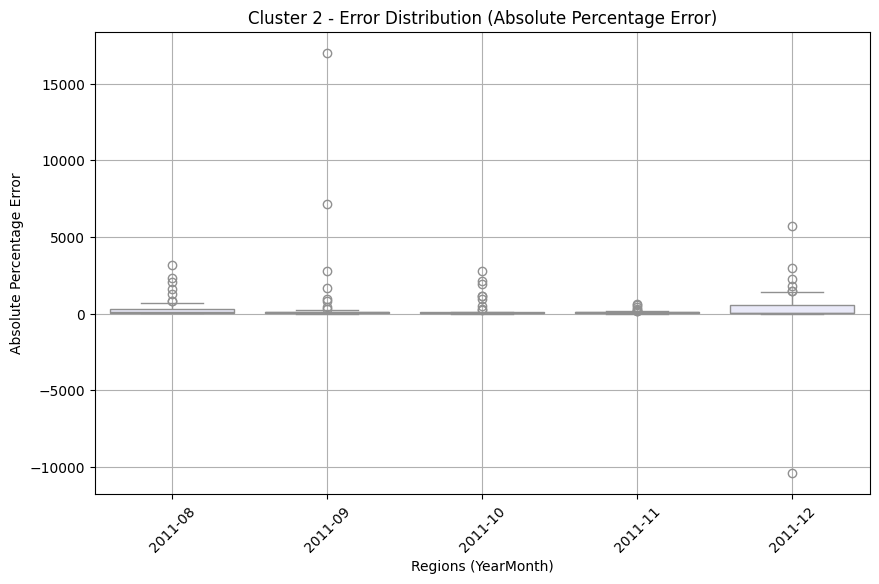

Cluster 2: MAPE Scores for each region:
  Region 2011-08: MAPE = 3.8695%
  Region 2011-09: MAPE = 7.9759%
  Region 2011-10: MAPE = 3.0867%
  Region 2011-11: MAPE = 1.1088%
  Region 2011-12: MAPE = 7.9663%


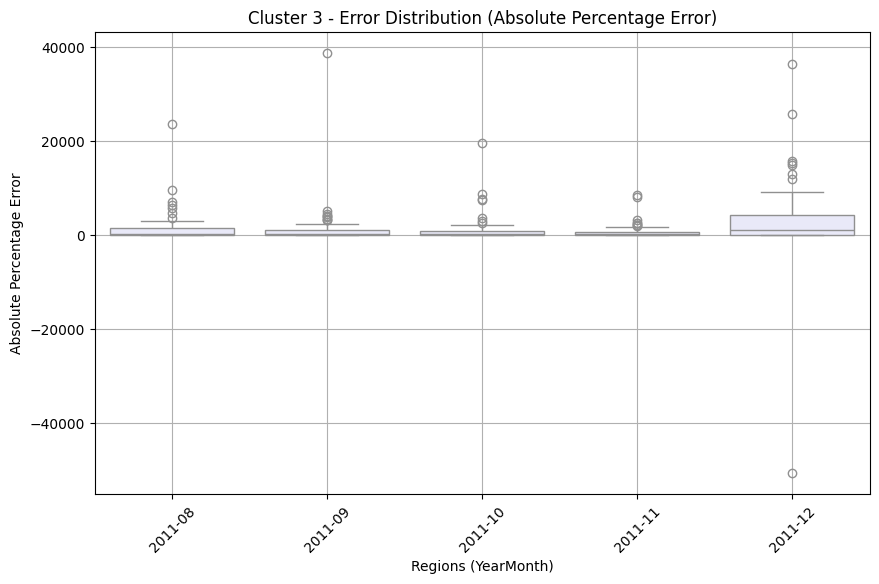

Cluster 3: MAPE Scores for each region:
  Region 2011-08: MAPE = 16.0514%
  Region 2011-09: MAPE = 15.8697%
  Region 2011-10: MAPE = 12.8113%
  Region 2011-11: MAPE = 8.2256%
  Region 2011-12: MAPE = 48.2972%


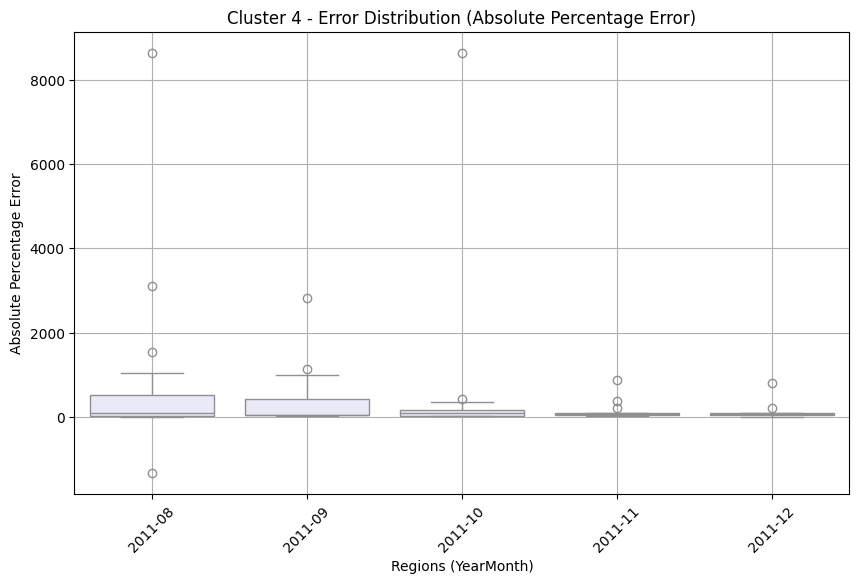

Cluster 4: MAPE Scores for each region:
  Region 2011-08: MAPE = 8.6586%
  Region 2011-09: MAPE = 3.4886%
  Region 2011-10: MAPE = 5.2189%
  Region 2011-11: MAPE = 1.2005%
  Region 2011-12: MAPE = 0.9698%


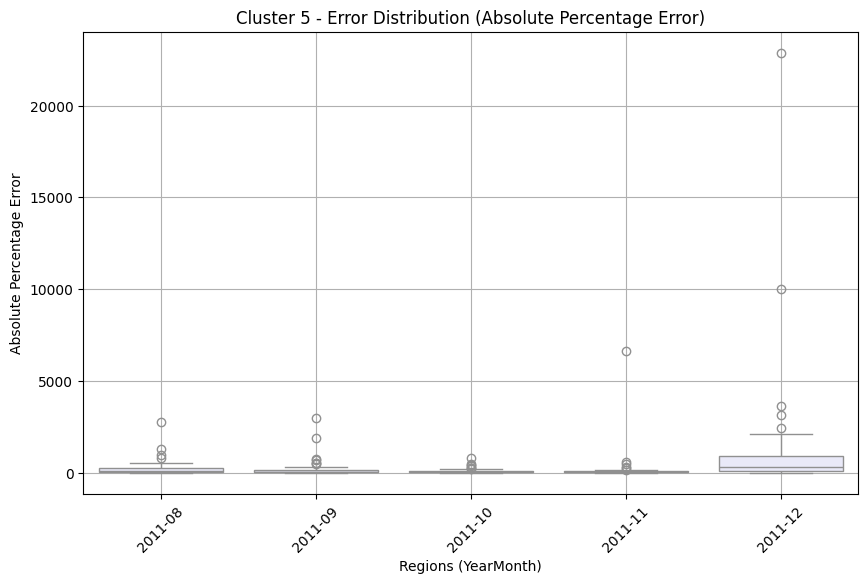

Cluster 5: MAPE Scores for each region:
  Region 2011-08: MAPE = 2.3670%
  Region 2011-09: MAPE = 2.3162%
  Region 2011-10: MAPE = 1.1092%
  Region 2011-11: MAPE = 2.2507%
  Region 2011-12: MAPE = 12.5834%


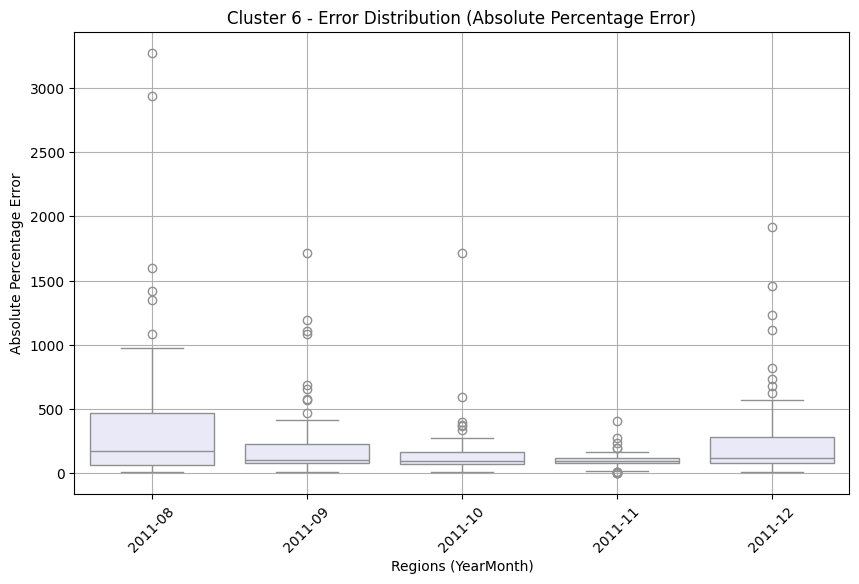

Cluster 6: MAPE Scores for each region:
  Region 2011-08: MAPE = 4.0529%
  Region 2011-09: MAPE = 2.4132%
  Region 2011-10: MAPE = 1.5776%
  Region 2011-11: MAPE = 0.9833%
  Region 2011-12: MAPE = 2.6446%


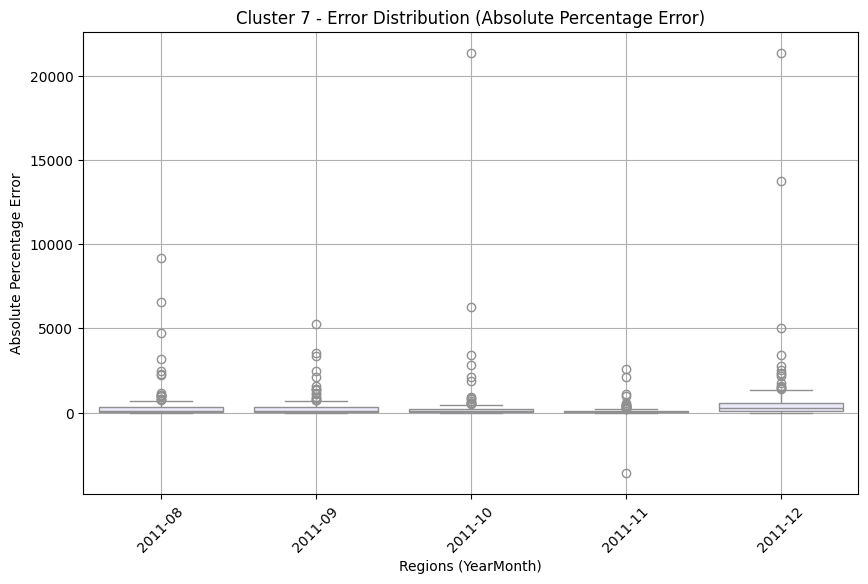

Cluster 7: MAPE Scores for each region:
  Region 2011-08: MAPE = 4.2924%
  Region 2011-09: MAPE = 3.4620%
  Region 2011-10: MAPE = 4.3564%
  Region 2011-11: MAPE = 1.6958%
  Region 2011-12: MAPE = 7.8580%


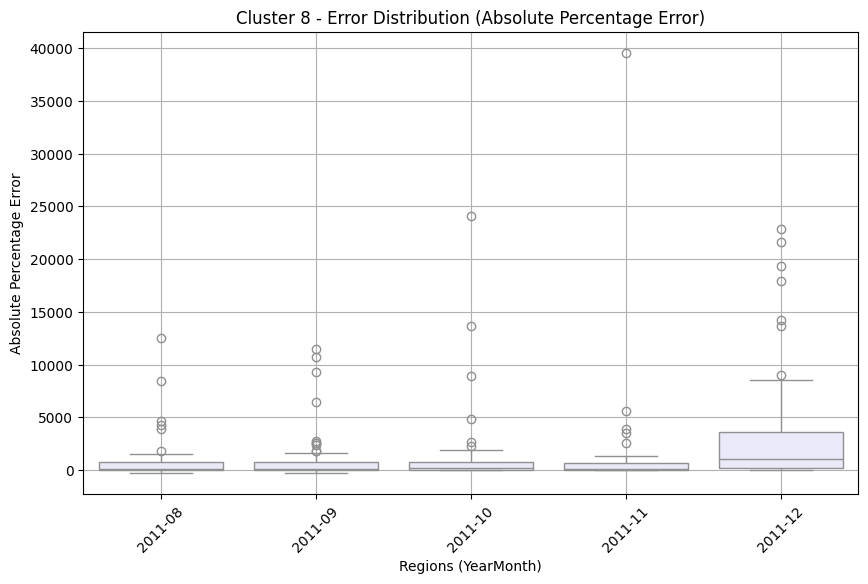

Cluster 8: MAPE Scores for each region:
  Region 2011-08: MAPE = 9.4909%
  Region 2011-09: MAPE = 11.7532%
  Region 2011-10: MAPE = 13.9676%
  Region 2011-11: MAPE = 12.7885%
  Region 2011-12: MAPE = 35.3583%

Overall MAPE Scores for each region (Across all clusters):
  Region 2011-08: MAPE = 6.8202%
  Region 2011-09: MAPE = 6.3242%
  Region 2011-10: MAPE = 5.5620%
  Region 2011-11: MAPE = 3.6914%
  Region 2011-12: MAPE = 15.4976%


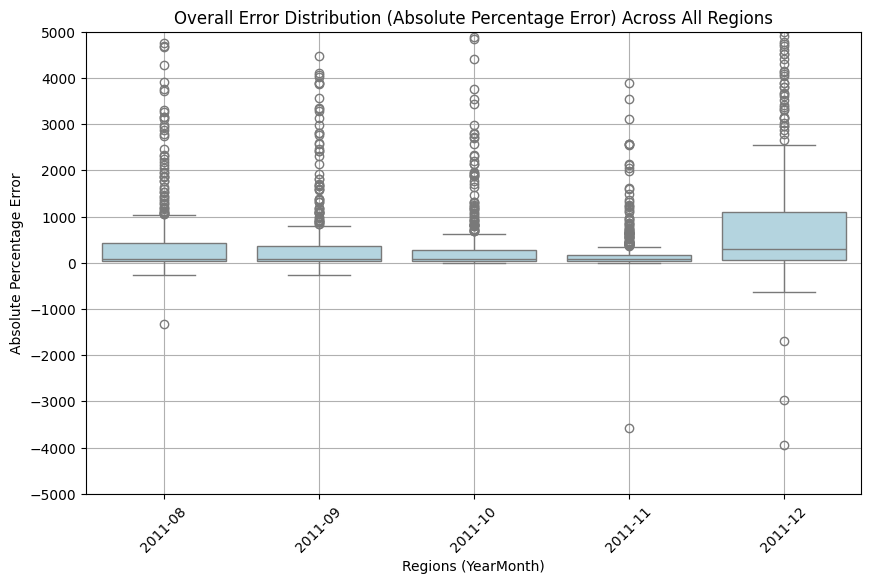

In [40]:
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.simplefilter(action='ignore', category=UserWarning)

data = pd.read_csv("FINAL_DATA.csv", parse_dates=["InvoiceDate"])
data.sort_values(by=["data_based_cluster", "InvoiceDate"], inplace=True)

data["total_sales"] = data["Quantity"] * data["Price"]
clusters = data["data_based_cluster"].unique()

cluster_dataframes = {cluster: data[data["data_based_cluster"] == cluster].copy() for cluster in clusters}

# Initialize dictionaries to store MAPE scores, models, predictions, and errors
mape_scores = {}
models = {}
all_preds = {}
all_errors = {}

# Overall MAPE for regions
overall_mape_scores = {region: [] for region in data["YearMonth"].unique()}

for cluster, cluster_data in cluster_dataframes.items():
    unique_descriptions = cluster_data["Description"].unique()
    desc = unique_descriptions[0]
    months_to_loop = cluster_data['YearMonth'].unique()

    total_data = cluster_data[(data["Description"] != desc)]
    one_product = cluster_data[(data["Description"] == desc)]

    total_data = total_data.sort_values(by="InvoiceDate")
    one_product = one_product.sort_values(by="InvoiceDate")

    # Train-test split (80% training, last 5 months for testing)
    train_data = total_data[total_data['YearMonth'].isin(months_to_loop[:20])]
    train_data_aggregated = train_data.groupby(['YearMonth', 'Description'])['total_sales'].sum().reset_index()

    test_data = total_data[total_data['YearMonth'].isin(months_to_loop[20:])]
    test_data_aggregated = test_data.groupby(['YearMonth', 'Description'])['total_sales'].sum().reset_index()

    try:
        model = SARIMAX(train_data_aggregated['total_sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)

    except Exception as e:
        print(f"Error in model for cluster {cluster}, Description {desc}: {e}")
        continue

    # Get unique YearMonth values for testing regions
    regions = test_data_aggregated['YearMonth'].unique()

    region_errors = {}  # Dictionary to store per-region error lists
    predictions = []

    # Initialize MAPE scores storage
    mape_scores[cluster] = {}

    for region in regions:
        region_data = test_data_aggregated[test_data_aggregated['YearMonth'] == region].copy()

        # Forecast for this region
        try:
            forecast_steps = len(region_data)
            preds = model_fit.forecast(steps=forecast_steps)

            # Store predictions in the DataFrame
            region_data["predicted_sales"] = preds.values

            # Compute individual absolute percentage errors
            region_data["absolute_percentage_error"] = (
                abs(region_data["total_sales"] - region_data["predicted_sales"]) / region_data["total_sales"]
            ) * 100

            # Store list of errors per region for boxplot visualization
            region_errors[region] = region_data["absolute_percentage_error"].tolist()

            mape = mean_absolute_percentage_error(region_data["total_sales"], region_data["predicted_sales"])

            # Store MAPE in the dictionary for this cluster and region
            mape_scores[cluster][region] = mape

            # Store predictions
            predictions.append(preds)

            # Store the errors for overall MAPE
            overall_mape_scores[region].extend(region_errors[region])

        except Exception as e:
            print(f"Error during forecasting for cluster {cluster}, Region {region}: {e}")
            continue

    # Convert region errors to a DataFrame for proper boxplot formatting
    error_data = []
    region_labels = []

    for region, errors in region_errors.items():
        for error in errors:  # Store multiple error values per region
            error_data.append(error)
            region_labels.append(region)

    error_df = pd.DataFrame({"Region": region_labels, "Absolute Percentage Error": error_data})

    # Plot the boxplot with regions correctly separated at the cluster level
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Region", y="Absolute Percentage Error", data=error_df, color='lavender')

    plt.xticks(rotation=45)
    plt.title(f"Cluster {cluster} - Error Distribution (Absolute Percentage Error)")
    plt.xlabel("Regions (YearMonth)")
    plt.ylabel("Absolute Percentage Error")
    plt.grid(True)
    plt.show()

    print(f"Cluster {cluster}: MAPE Scores for each region:")
    for region, mape in mape_scores[cluster].items():
        print(f"  Region {region}: MAPE = {mape:.4f}%")

# Now compute overall MAPE across all clusters for each region (without the cluster level)
overall_mape_scores_final = {}

# Remove keys with empty lists from the overall_mape_scores dictionary
overall_mape_scores = {region: errors for region, errors in overall_mape_scores.items() if errors}


# Calculate the overall MAPE for each region across all clusters
for cluster in mape_scores:
    for region, mape in mape_scores[cluster].items():
        if region not in overall_mape_scores_final:
            overall_mape_scores_final[region] = []
        overall_mape_scores_final[region].append(mape)

# Calculate the mean MAPE for each region across all clusters
for region, errors in overall_mape_scores_final.items():
    overall_mape_scores_final[region] = sum(errors) / len(errors)

# Print overall MAPE scores for each region
print("\nOverall MAPE Scores for each region (Across all clusters):")
for region, mape in overall_mape_scores_final.items():
    print(f"  Region {region}: MAPE = {mape:.4f}%")

# Plot the overall boxplots for each region across all clusters
overall_error_data = []
overall_region_labels = []

for region, errors in overall_mape_scores.items():
    for error in errors:  # Store multiple error values per region
        overall_error_data.append(error)
        overall_region_labels.append(region)

overall_error_df = pd.DataFrame({"Region": overall_region_labels, "Absolute Percentage Error": overall_error_data})

# Plot the boxplot for all regions combined (no cluster breakdown)
plt.figure(figsize=(10, 6))
sns.boxplot(x="Region", y="Absolute Percentage Error", data=overall_error_df, color='lightblue')

plt.xticks(rotation=45)
plt.title(f"Overall Error Distribution (Absolute Percentage Error) Across All Regions")
plt.xlabel("Regions (YearMonth)")
plt.ylabel("Absolute Percentage Error")
plt.grid(True)

# Set the y-axis limit to 40,000 and tick intervals to 10,000
plt.ylim(-5000, 5000)
plt.yticks(range(-5000, 5001, 1000))  # Labels at intervals of 10,000

plt.show()

## SARIMAX, description based clustering

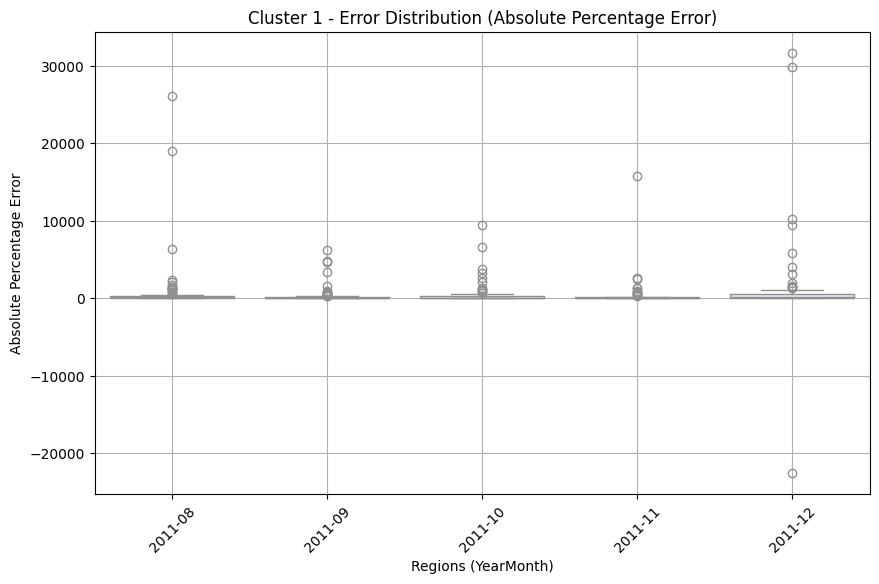

Cluster 1: MAPE Scores for each region:
  Region 2011-08: MAPE = 9.3212%
  Region 2011-09: MAPE = 4.0609%
  Region 2011-10: MAPE = 5.2578%
  Region 2011-11: MAPE = 4.3286%
  Region 2011-12: MAPE = 17.0820%


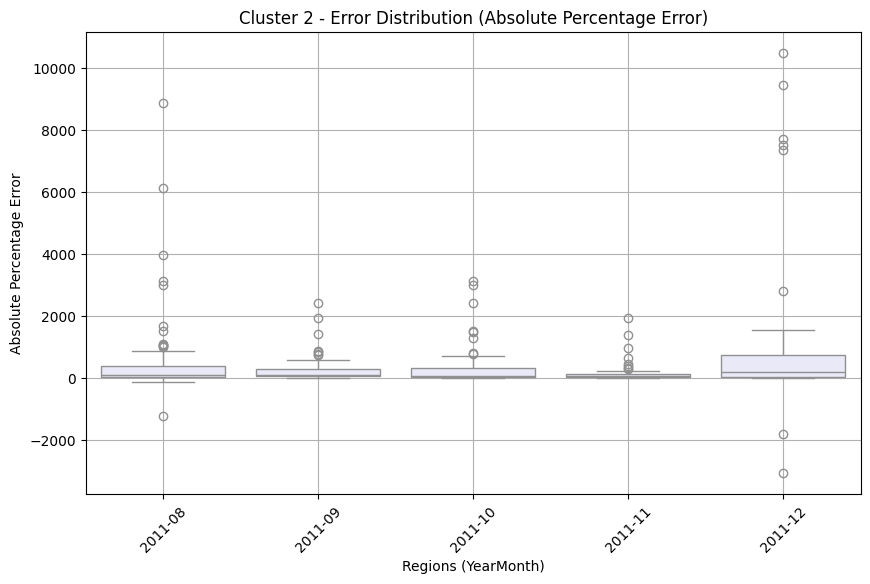

Cluster 2: MAPE Scores for each region:
  Region 2011-08: MAPE = 5.8381%
  Region 2011-09: MAPE = 2.4490%
  Region 2011-10: MAPE = 3.0880%
  Region 2011-11: MAPE = 1.5181%
  Region 2011-12: MAPE = 9.8027%


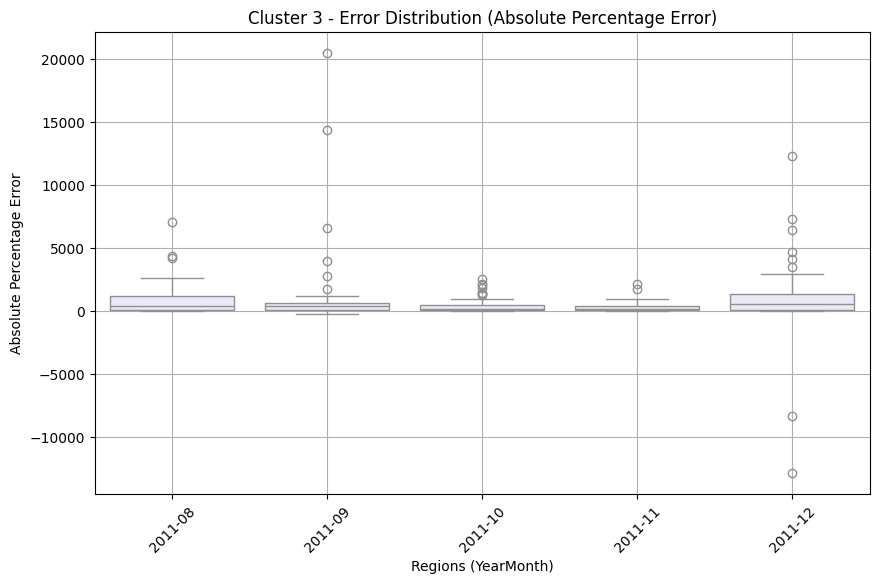

Cluster 3: MAPE Scores for each region:
  Region 2011-08: MAPE = 9.1772%
  Region 2011-09: MAPE = 12.5545%
  Region 2011-10: MAPE = 4.7350%
  Region 2011-11: MAPE = 3.1764%
  Region 2011-12: MAPE = 16.7784%


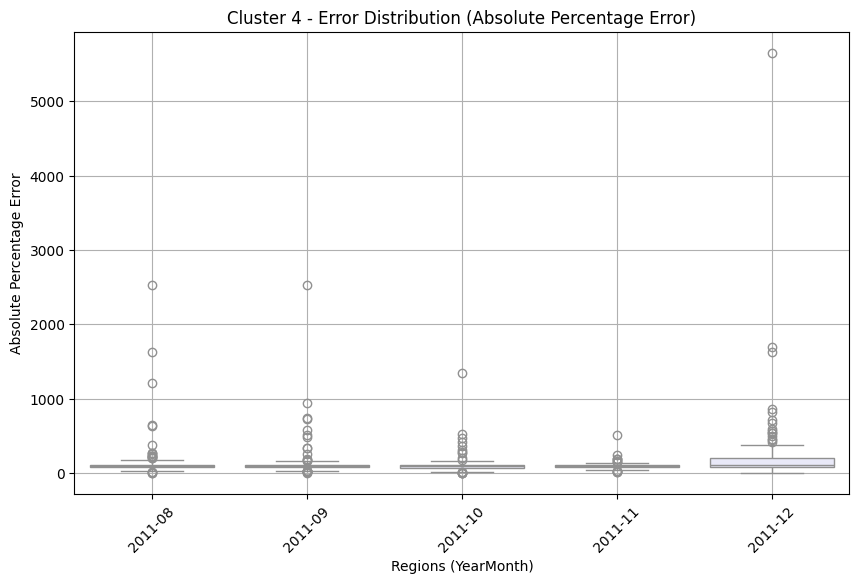

Cluster 4: MAPE Scores for each region:
  Region 2011-08: MAPE = 1.6187%
  Region 2011-09: MAPE = 1.5322%
  Region 2011-10: MAPE = 1.1642%
  Region 2011-11: MAPE = 0.9733%
  Region 2011-12: MAPE = 2.6021%


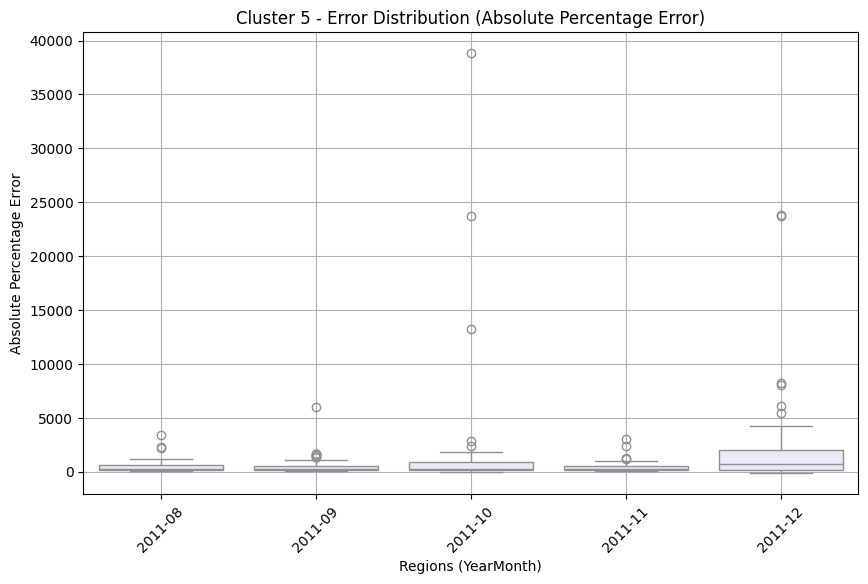

Cluster 5: MAPE Scores for each region:
  Region 2011-08: MAPE = 4.7172%
  Region 2011-09: MAPE = 5.4242%
  Region 2011-10: MAPE = 18.7898%
  Region 2011-11: MAPE = 4.1906%
  Region 2011-12: MAPE = 22.5150%


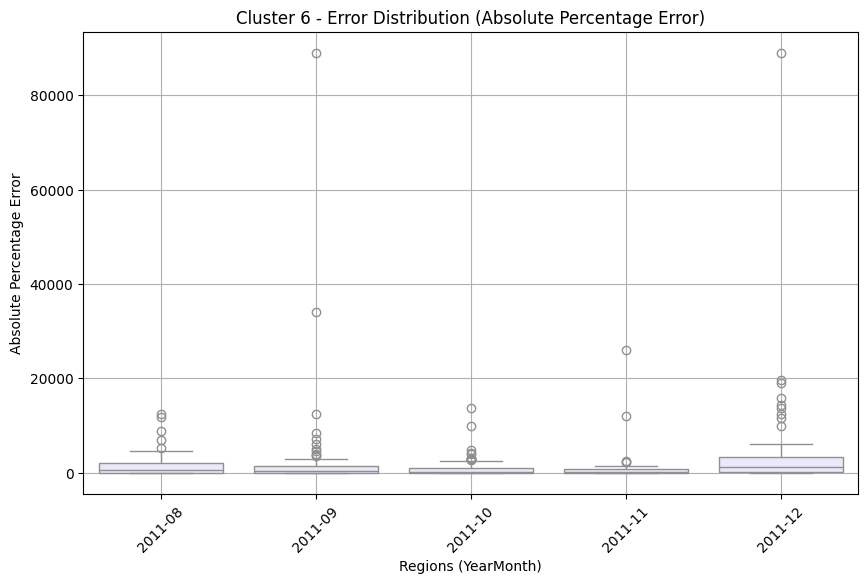

Cluster 6: MAPE Scores for each region:
  Region 2011-08: MAPE = 16.2719%
  Region 2011-09: MAPE = 31.4531%
  Region 2011-10: MAPE = 11.4479%
  Region 2011-11: MAPE = 10.5320%
  Region 2011-12: MAPE = 43.7180%


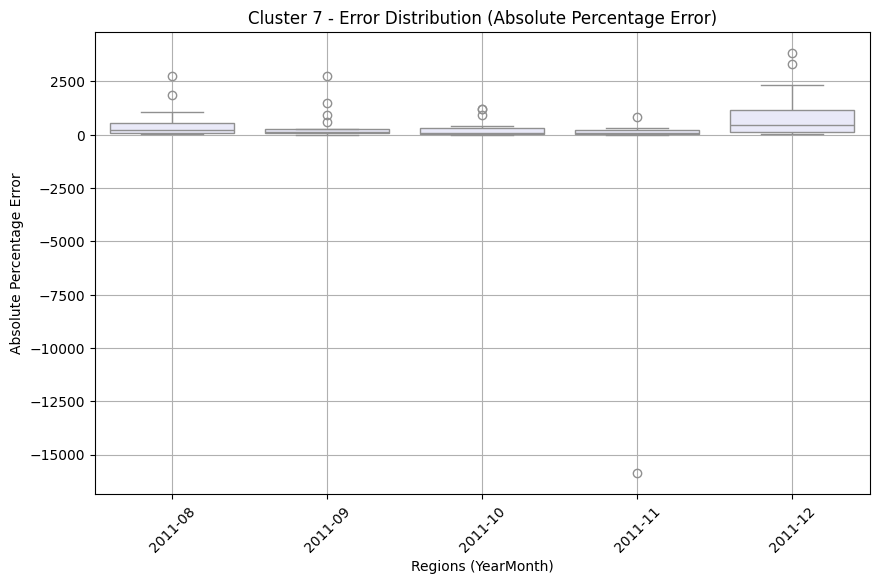

Cluster 7: MAPE Scores for each region:
  Region 2011-08: MAPE = 5.0757%
  Region 2011-09: MAPE = 3.9521%
  Region 2011-10: MAPE = 2.8009%
  Region 2011-11: MAPE = 10.2690%
  Region 2011-12: MAPE = 9.5383%


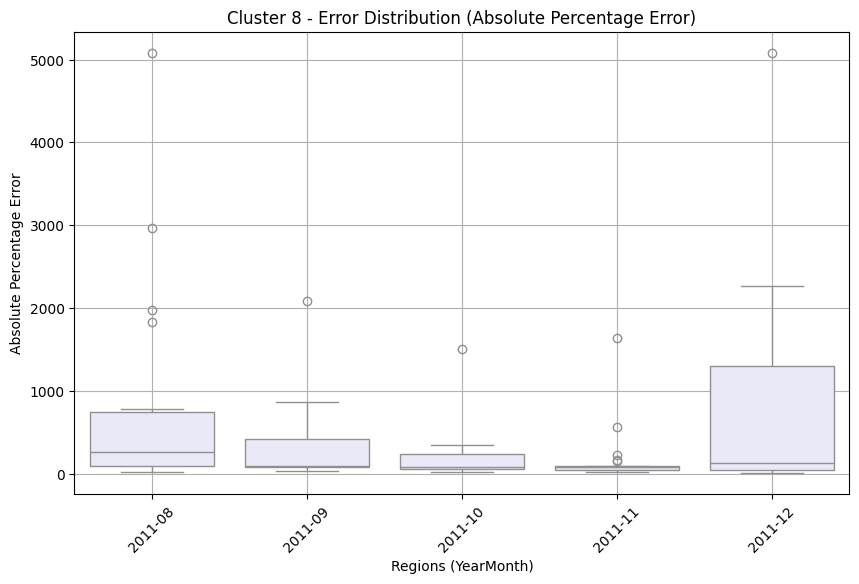

Cluster 8: MAPE Scores for each region:
  Region 2011-08: MAPE = 7.7745%
  Region 2011-09: MAPE = 3.3454%
  Region 2011-10: MAPE = 1.8911%
  Region 2011-11: MAPE = 1.7682%
  Region 2011-12: MAPE = 8.0742%


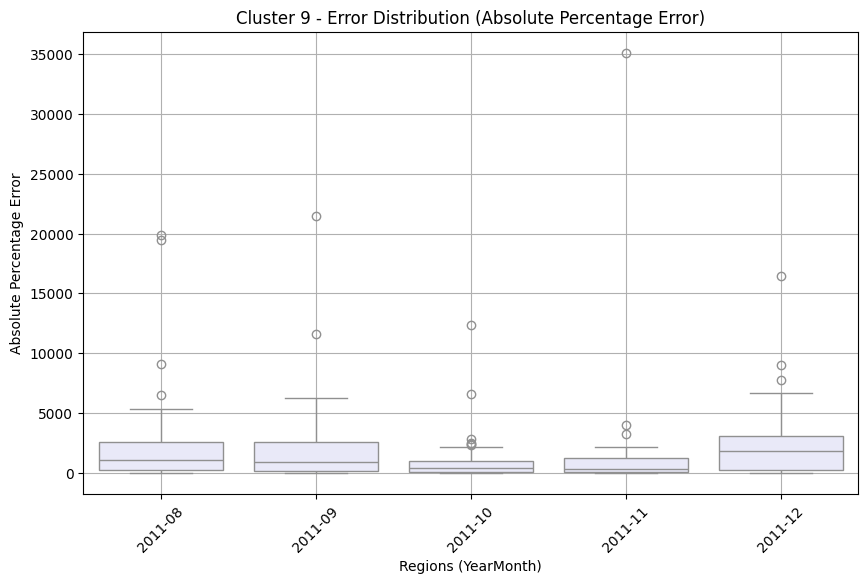

Cluster 9: MAPE Scores for each region:
  Region 2011-08: MAPE = 26.2096%
  Region 2011-09: MAPE = 22.1386%
  Region 2011-10: MAPE = 11.3398%
  Region 2011-11: MAPE = 15.7465%
  Region 2011-12: MAPE = 25.2855%


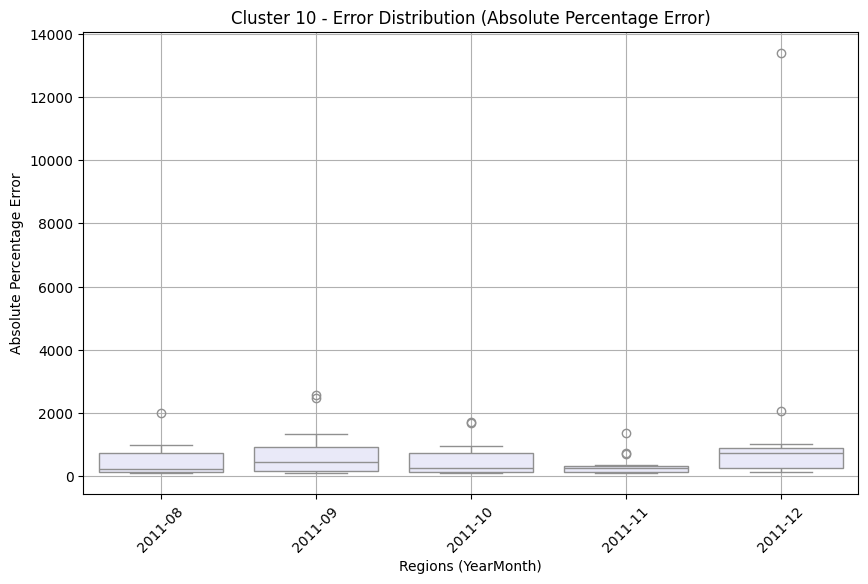

Cluster 10: MAPE Scores for each region:
  Region 2011-08: MAPE = 4.7380%
  Region 2011-09: MAPE = 7.2812%
  Region 2011-10: MAPE = 5.3577%
  Region 2011-11: MAPE = 3.5258%
  Region 2011-12: MAPE = 14.7553%


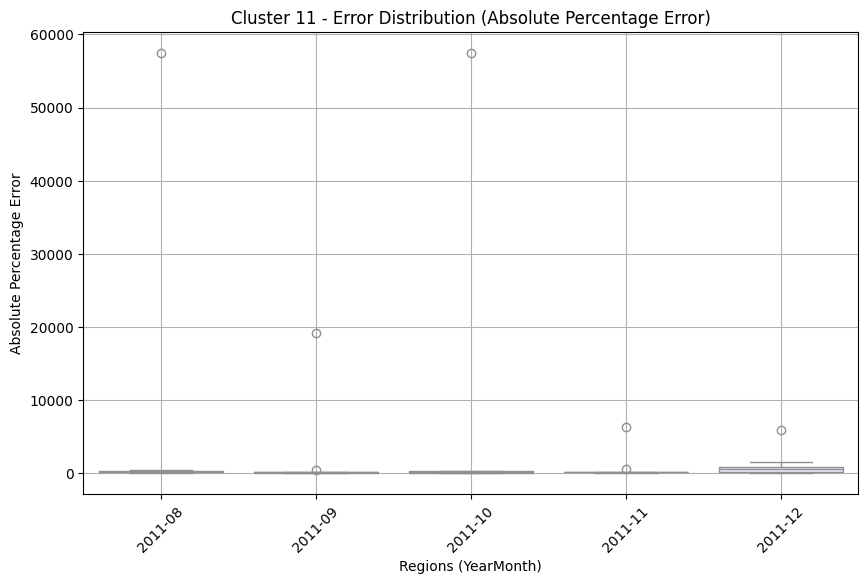

Cluster 11: MAPE Scores for each region:
  Region 2011-08: MAPE = 58.8621%
  Region 2011-09: MAPE = 20.0443%
  Region 2011-10: MAPE = 58.5655%
  Region 2011-11: MAPE = 7.5395%
  Region 2011-12: MAPE = 10.2870%

Overall MAPE Scores for each region (Across all clusters):
  Region 2011-08: MAPE = 13.6004%
  Region 2011-09: MAPE = 10.3850%
  Region 2011-10: MAPE = 11.3125%
  Region 2011-11: MAPE = 5.7789%
  Region 2011-12: MAPE = 16.4035%


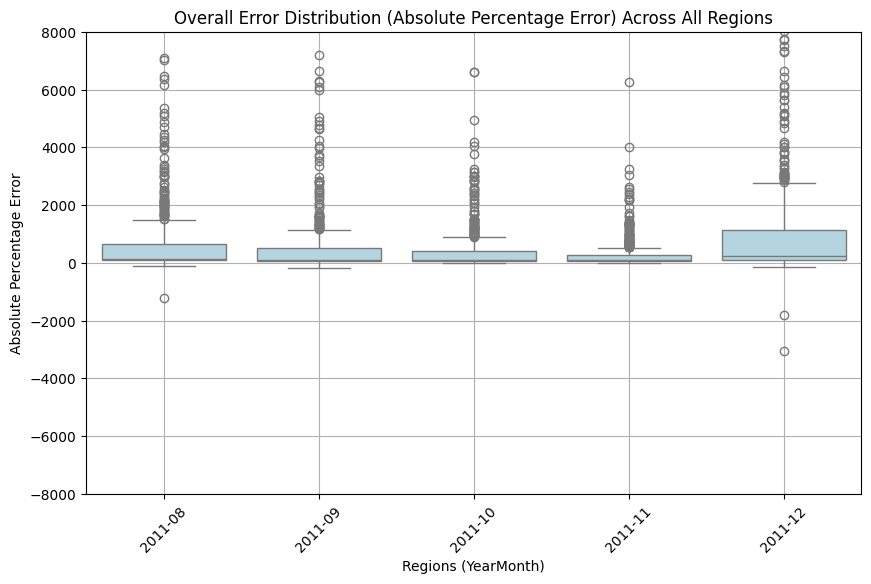

In [43]:
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.simplefilter(action='ignore', category=UserWarning)

# Read the data
data = pd.read_csv("FINAL_DATA.csv", parse_dates=["InvoiceDate"])
data.sort_values(by=["desc_based_cluster", "InvoiceDate"], inplace=True)

# Create total sales column
data["total_sales"] = data["Quantity"] * data["Price"]

data['SP500_Close'] = data['SP500_Close'].replace({'\$': '', ',': ''}, regex=True)
data['SP500_Close'] = pd.to_numeric(data['SP500_Close'], errors='coerce')
data['CPI'] = pd.to_numeric(data['CPI'], errors='coerce')

# Extract unique clusters
clusters = data["desc_based_cluster"].unique()
cluster_dataframes = {cluster: data[data["desc_based_cluster"] == cluster].copy() for cluster in clusters}

# Initialize dictionaries to store MAPE scores, models, predictions, and errors
mape_scores = {}
models = {}
all_preds = {}
all_errors = {}

# Overall MAPE for regions
overall_mape_scores = {region: [] for region in data["YearMonth"].unique()}

for cluster, cluster_data in cluster_dataframes.items():
    unique_descriptions = cluster_data["Description"].unique()
    desc = unique_descriptions[0]
    months_to_loop = cluster_data['YearMonth'].unique()

    # Split into total_data (all descriptions except the one of interest) and one_product data
    total_data = cluster_data[(data["Description"] != desc)]
    one_product = cluster_data[(data["Description"] == desc)]

    total_data = total_data.sort_values(by="InvoiceDate")
    one_product = one_product.sort_values(by="InvoiceDate")

    # Split: first 80% for training, next 20% for testing (5 regions)
    train_data = total_data[total_data['YearMonth'].isin(months_to_loop[:20])]
    train_data_aggregated = train_data.groupby(['YearMonth', 'Description'])['total_sales'].sum().reset_index()

    test_data = total_data[total_data['YearMonth'].isin(months_to_loop[20:])]
    test_data_aggregated = test_data.groupby(['YearMonth', 'Description'])['total_sales'].sum().reset_index()

    # Merge the exogenous variables (SP500_Close and CPI) with the aggregated data
    train_data_aggregated = train_data_aggregated.merge(
        train_data[['YearMonth', 'SP500_Close', 'CPI']].drop_duplicates(),
        on='YearMonth',
        how='left'
    )

    test_data_aggregated = test_data_aggregated.merge(
        test_data[['YearMonth', 'SP500_Close', 'CPI']].drop_duplicates(),
        on='YearMonth',
        how='left'
    )

    train_data_aggregated.dropna(subset=['SP500_Close', 'CPI'], inplace=True)
    test_data_aggregated.dropna(subset=['SP500_Close', 'CPI'], inplace=True)

    # Define exogenous variables
    exog_train = train_data_aggregated[['SP500_Close', 'CPI']]  # Exogenous variables for training data
    exog_test = test_data_aggregated[['SP500_Close', 'CPI']]  # Exogenous variables for test data

    try:
        # Fit SARIMAX model with exogenous variables
        model = SARIMAX(
            train_data_aggregated['total_sales'],
            exog=exog_train,  # Pass exogenous variables for training
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)

    except Exception as e:
        print(f"Error in model for cluster {cluster}, Description {desc}: {e}")
        continue

    # Split the test data based on the YearMonth (each unique YearMonth is a region)
    regions = test_data_aggregated['YearMonth'].unique()

    region_errors = {}  # Dictionary to store per-region error lists
    predictions = []

    # Initialize MAPE scores storage
    mape_scores[cluster] = {}


    for region in regions:
        region_data = test_data_aggregated[test_data_aggregated['YearMonth'] == region]

        # Forecast for the given region (we use `steps=1` because it's for a single month)
        try:
            forecast_steps = len(region_data)

            # Ensure that exog_test is correctly sliced with the appropriate shape
            exog_region = exog_test.iloc[:forecast_steps]  # Use the forecast_steps to slice correctly

            # Generate predictions using exogenous variables
            preds = model_fit.forecast(steps=forecast_steps, exog=exog_region)

            # Align predictions with the test data
            region_data = region_data.copy()
            region_data["predicted_sales"] = preds.values

            # Compute individual absolute percentage errors
            region_data["absolute_percentage_error"] = (
                abs(region_data["total_sales"] - region_data["predicted_sales"]) / region_data["total_sales"]
            ) * 100

            # Store list of errors per region for boxplot visualization
            region_errors[region] = region_data["absolute_percentage_error"].tolist()

            mape = mean_absolute_percentage_error(region_data["total_sales"], region_data["predicted_sales"])

            # Store MAPE in the dictionary for this cluster and region
            mape_scores[cluster][region] = mape

            # Store predictions
            predictions.append(preds)

            # Store the errors for overall MAPE
            overall_mape_scores[region].extend(region_errors[region])

        except Exception as e:
            print(f"Error during forecasting for cluster {cluster}, Region {region}: {e}")
            continue

    # Convert region errors to a DataFrame for proper boxplot formatting
    error_data = []
    region_labels = []

    for region, errors in region_errors.items():
        for error in errors:  # Store multiple error values per region
            error_data.append(error)
            region_labels.append(region)

    error_df = pd.DataFrame({"Region": region_labels, "Absolute Percentage Error": error_data})

    # Plot the boxplot with regions correctly separated at the cluster level
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Region", y="Absolute Percentage Error", data=error_df, color='lavender')

    plt.xticks(rotation=45)
    plt.title(f"Cluster {cluster} - Error Distribution (Absolute Percentage Error)")
    plt.xlabel("Regions (YearMonth)")
    plt.ylabel("Absolute Percentage Error")
    plt.grid(True)
    plt.show()

    print(f"Cluster {cluster}: MAPE Scores for each region:")
    for region, mape in mape_scores[cluster].items():
        print(f"  Region {region}: MAPE = {mape:.4f}%")

# Now compute overall MAPE across all clusters for each region (without the cluster level)
overall_mape_scores_final = {}

# Remove keys with empty lists from the overall_mape_scores dictionary
overall_mape_scores = {region: errors for region, errors in overall_mape_scores.items() if errors}


# Calculate the overall MAPE for each region across all clusters
for cluster in mape_scores:
    for region, mape in mape_scores[cluster].items():
        if region not in overall_mape_scores_final:
            overall_mape_scores_final[region] = []
        overall_mape_scores_final[region].append(mape)

# Calculate the mean MAPE for each region across all clusters
for region, errors in overall_mape_scores_final.items():
    overall_mape_scores_final[region] = sum(errors) / len(errors)

# Print overall MAPE scores for each region
print("\nOverall MAPE Scores for each region (Across all clusters):")
for region, mape in overall_mape_scores_final.items():
    print(f"  Region {region}: MAPE = {mape:.4f}%")

# Plot the overall boxplots for each region across all clusters
overall_error_data = []
overall_region_labels = []

for region, errors in overall_mape_scores.items():
    for error in errors:  # Store multiple error values per region
        overall_error_data.append(error)
        overall_region_labels.append(region)

overall_error_df = pd.DataFrame({"Region": overall_region_labels, "Absolute Percentage Error": overall_error_data})

# Plot the boxplot for all regions combined (no cluster breakdown)
plt.figure(figsize=(10, 6))
sns.boxplot(x="Region", y="Absolute Percentage Error", data=overall_error_df, color='lightblue')

plt.xticks(rotation=45)
plt.title(f"Overall Error Distribution (Absolute Percentage Error) Across All Regions")
plt.xlabel("Regions (YearMonth)")
plt.ylabel("Absolute Percentage Error")
plt.grid(True)

# Set the y-axis limit to 40,000 and tick intervals to 10,000
plt.ylim(-8000, 8000)
plt.yticks(range(-8000, 8001, 2000))  # Labels at intervals of 10,000

plt.show()

## SARIMAX, data based clustering

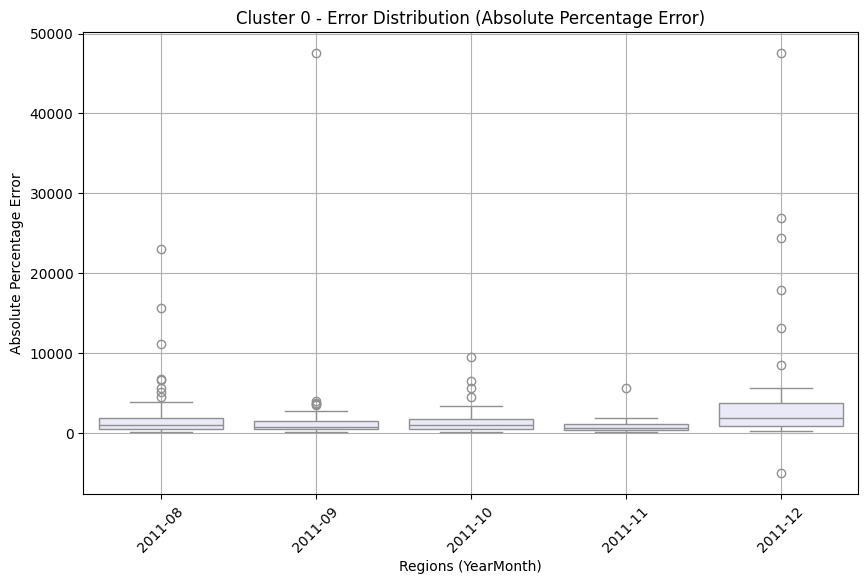

Cluster 0: MAPE Scores for each region:
  Region 2011-08: MAPE = 26.7384%
  Region 2011-09: MAPE = 23.3607%
  Region 2011-10: MAPE = 15.5477%
  Region 2011-11: MAPE = 8.5004%
  Region 2011-12: MAPE = 52.3678%


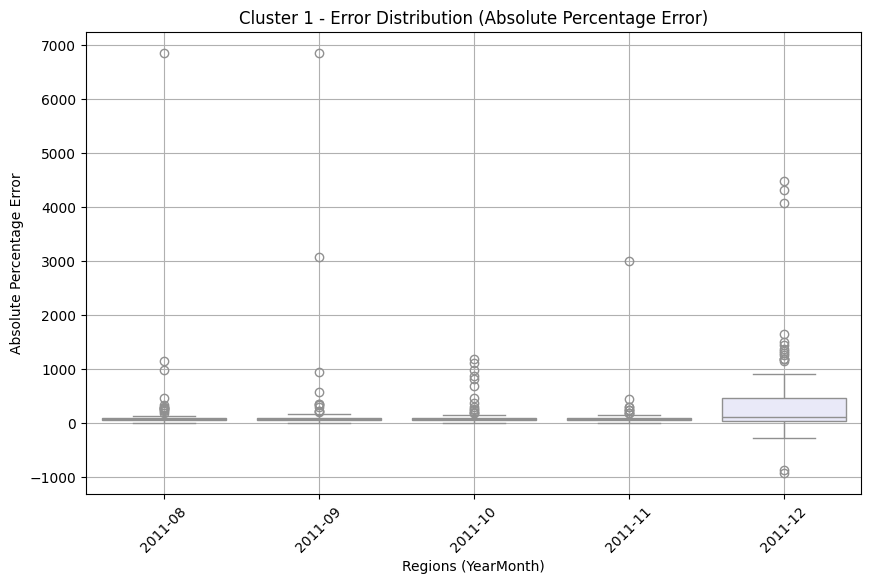

Cluster 1: MAPE Scores for each region:
  Region 2011-08: MAPE = 1.8110%
  Region 2011-09: MAPE = 1.9823%
  Region 2011-10: MAPE = 1.3606%
  Region 2011-11: MAPE = 1.1231%
  Region 2011-12: MAPE = 4.6988%


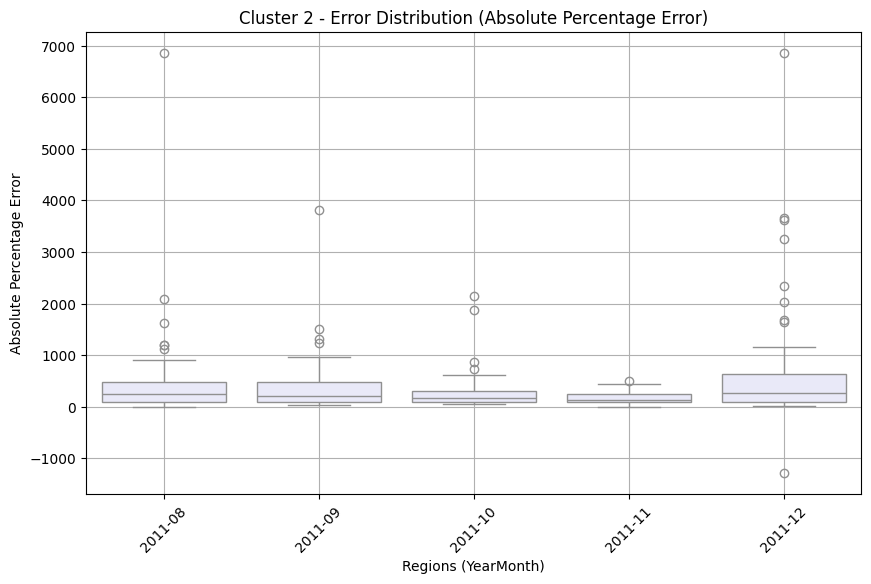

Cluster 2: MAPE Scores for each region:
  Region 2011-08: MAPE = 5.5262%
  Region 2011-09: MAPE = 4.4351%
  Region 2011-10: MAPE = 3.1767%
  Region 2011-11: MAPE = 1.8003%
  Region 2011-12: MAPE = 8.4018%


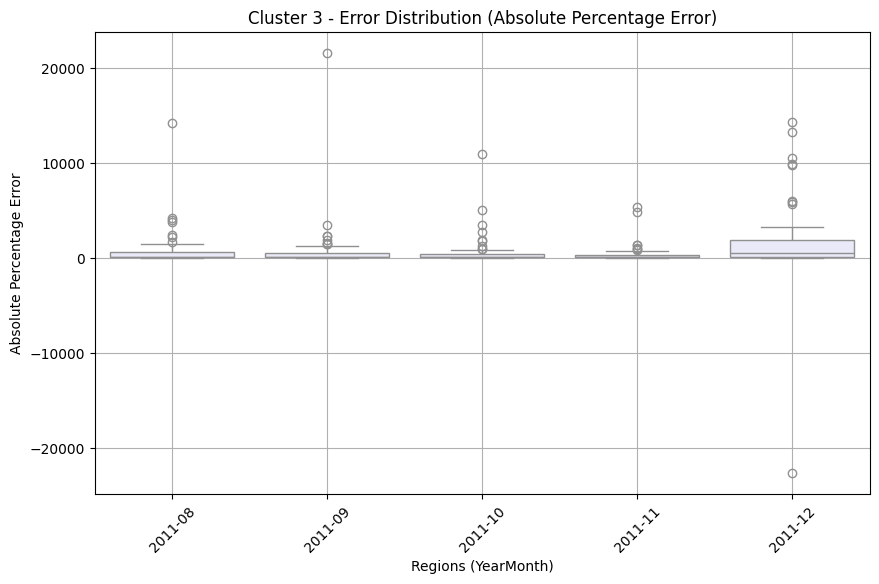

Cluster 3: MAPE Scores for each region:
  Region 2011-08: MAPE = 8.3368%
  Region 2011-09: MAPE = 8.3442%
  Region 2011-10: MAPE = 6.5338%
  Region 2011-11: MAPE = 4.3150%
  Region 2011-12: MAPE = 24.0114%


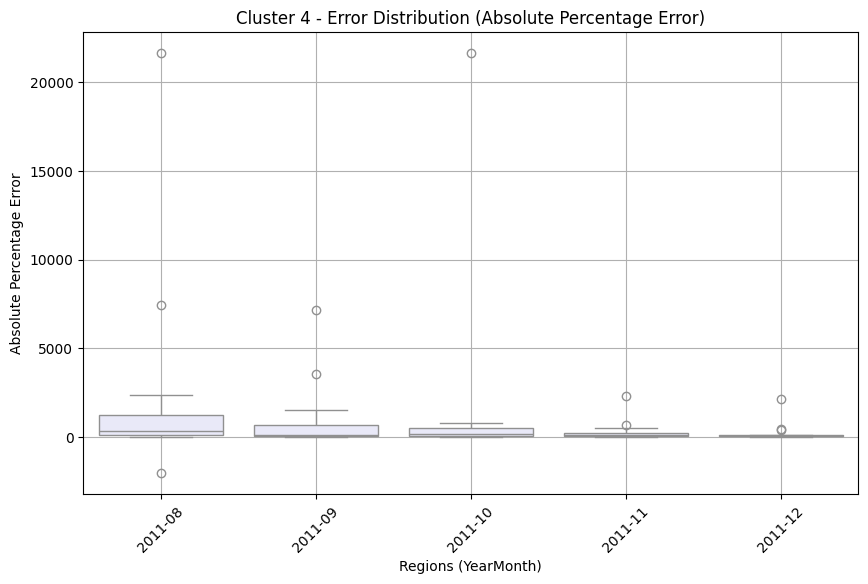

Cluster 4: MAPE Scores for each region:
  Region 2011-08: MAPE = 19.6364%
  Region 2011-09: MAPE = 7.7687%
  Region 2011-10: MAPE = 12.6531%
  Region 2011-11: MAPE = 2.6095%
  Region 2011-12: MAPE = 1.9286%


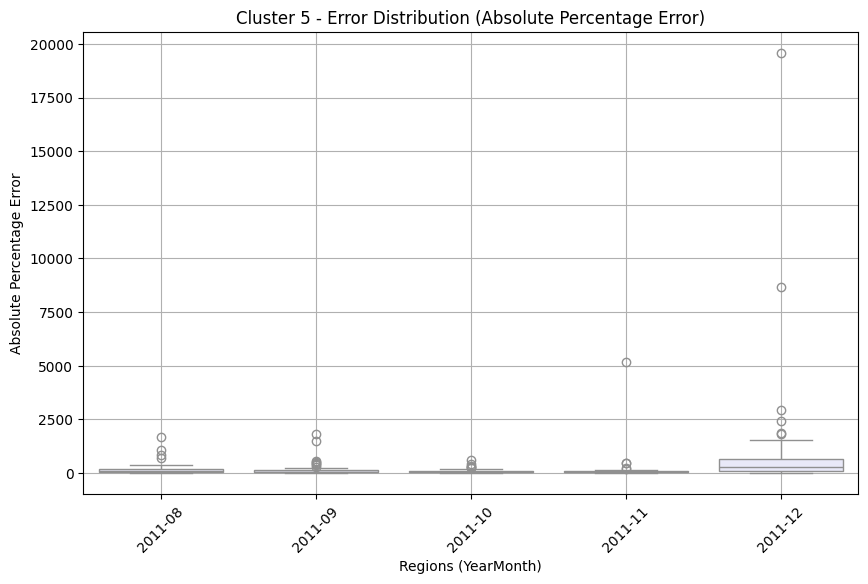

Cluster 5: MAPE Scores for each region:
  Region 2011-08: MAPE = 1.8176%
  Region 2011-09: MAPE = 1.7259%
  Region 2011-10: MAPE = 0.9231%
  Region 2011-11: MAPE = 1.8495%
  Region 2011-12: MAPE = 10.4326%


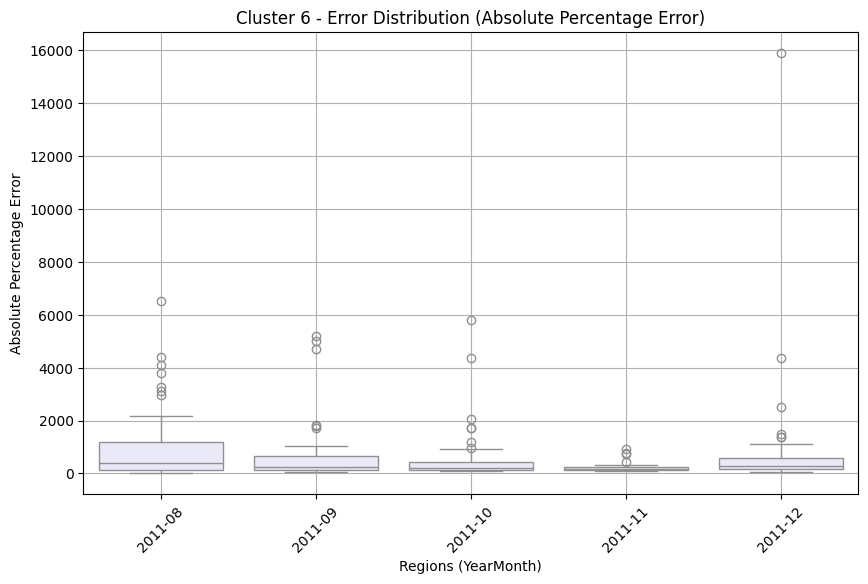

Cluster 6: MAPE Scores for each region:
  Region 2011-08: MAPE = 9.4969%
  Region 2011-09: MAPE = 6.3381%
  Region 2011-10: MAPE = 5.1731%
  Region 2011-11: MAPE = 2.0738%
  Region 2011-12: MAPE = 7.5760%


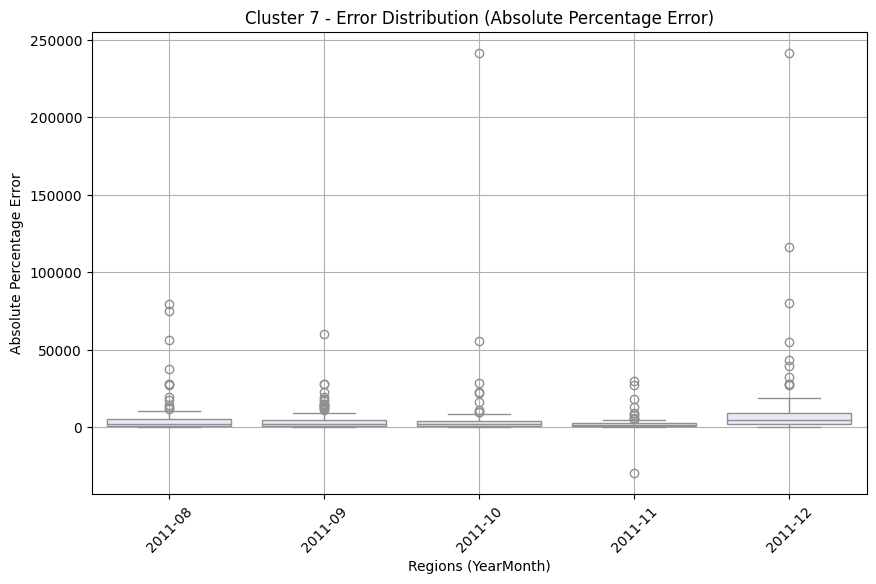

Cluster 7: MAPE Scores for each region:
  Region 2011-08: MAPE = 56.9257%
  Region 2011-09: MAPE = 44.9411%
  Region 2011-10: MAPE = 52.6420%
  Region 2011-11: MAPE = 26.1386%
  Region 2011-12: MAPE = 102.7617%


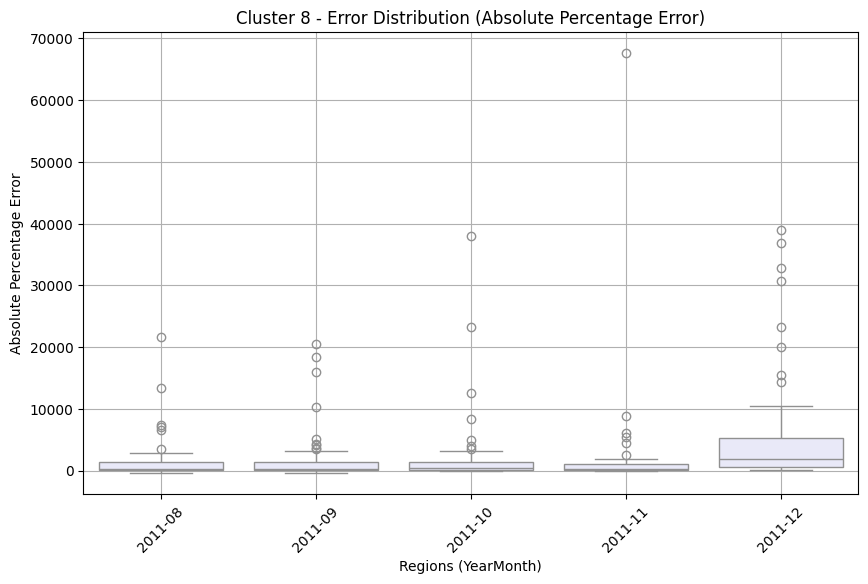

Cluster 8: MAPE Scores for each region:
  Region 2011-08: MAPE = 16.1269%
  Region 2011-09: MAPE = 20.1895%
  Region 2011-10: MAPE = 23.2059%
  Region 2011-11: MAPE = 21.8571%
  Region 2011-12: MAPE = 59.8407%

Overall MAPE Scores for each region (Across all clusters):
  Region 2011-08: MAPE = 16.2684%
  Region 2011-09: MAPE = 13.2317%
  Region 2011-10: MAPE = 13.4684%
  Region 2011-11: MAPE = 7.8075%
  Region 2011-12: MAPE = 30.2244%


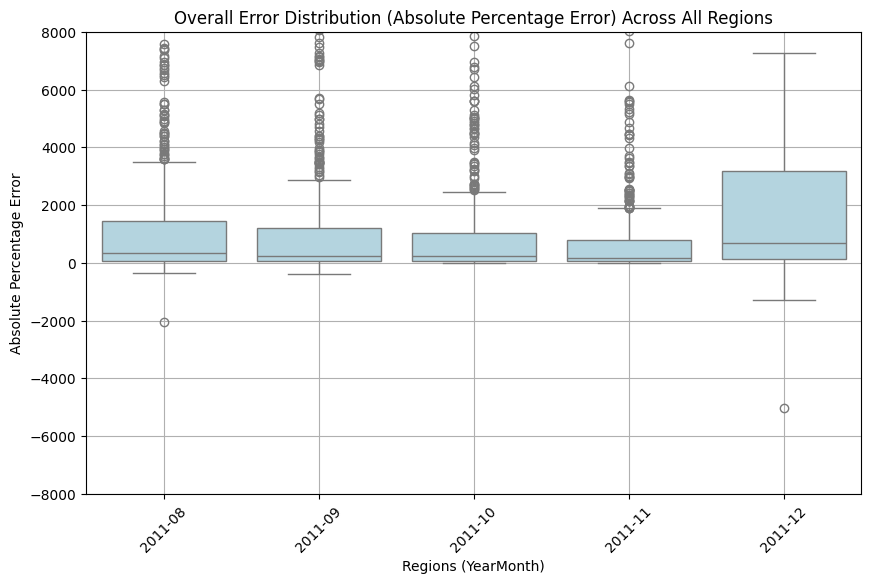

In [42]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

data = pd.read_csv("FINAL_DATA.csv", parse_dates=["InvoiceDate"])
data.sort_values(by=["data_based_cluster", "InvoiceDate"], inplace=True)

# Create total sales column
data["total_sales"] = data["Quantity"] * data["Price"]

data['SP500_Close'] = data['SP500_Close'].replace({'\$': '', ',': ''}, regex=True)
data['SP500_Close'] = pd.to_numeric(data['SP500_Close'], errors='coerce')
data['CPI'] = pd.to_numeric(data['CPI'], errors='coerce')

# Extract unique clusters
clusters = data["data_based_cluster"].unique()
cluster_dataframes = {cluster: data[data["data_based_cluster"] == cluster].copy() for cluster in clusters}

# Initialize dictionaries to store MAPE scores, models, predictions, and errors
mape_scores = {}
models = {}
all_preds = {}
all_errors = {}

# Overall MAPE for regions
overall_mape_scores = {region: [] for region in data["YearMonth"].unique()}

for cluster, cluster_data in cluster_dataframes.items():
    unique_descriptions = cluster_data["Description"].unique()
    desc = unique_descriptions[0]
    months_to_loop = cluster_data['YearMonth'].unique()

    # Split into total_data (all descriptions except the one of interest) and one_product data
    total_data = cluster_data[(data["Description"] != desc)]
    one_product = cluster_data[(data["Description"] == desc)]

    total_data = total_data.sort_values(by="InvoiceDate")
    one_product = one_product.sort_values(by="InvoiceDate")

    # Split: first 80% for training, next 20% for testing (5 regions)
    train_data = total_data[total_data['YearMonth'].isin(months_to_loop[:20])]
    train_data_aggregated = train_data.groupby(['YearMonth', 'Description'])['total_sales'].sum().reset_index()

    test_data = total_data[total_data['YearMonth'].isin(months_to_loop[20:])]
    test_data_aggregated = test_data.groupby(['YearMonth', 'Description'])['total_sales'].sum().reset_index()

    # Merge the exogenous variables (SP500_Close and CPI) with the aggregated data
    train_data_aggregated = train_data_aggregated.merge(
        train_data[['YearMonth', 'SP500_Close', 'CPI']].drop_duplicates(),
        on='YearMonth',
        how='left'
    )

    test_data_aggregated = test_data_aggregated.merge(
        test_data[['YearMonth', 'SP500_Close', 'CPI']].drop_duplicates(),
        on='YearMonth',
        how='left'
    )

    train_data_aggregated.dropna(subset=['SP500_Close', 'CPI'], inplace=True)
    test_data_aggregated.dropna(subset=['SP500_Close', 'CPI'], inplace=True)

    # Define exogenous variables
    exog_train = train_data_aggregated[['SP500_Close', 'CPI']]  # Exogenous variables for training data
    exog_test = test_data_aggregated[['SP500_Close', 'CPI']]  # Exogenous variables for test data

    try:
        # Fit SARIMAX model with exogenous variables
        model = SARIMAX(
            train_data_aggregated['total_sales'],
            exog=exog_train,  # Pass exogenous variables for training
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)

    except Exception as e:
        print(f"Error in model for cluster {cluster}, Description {desc}: {e}")
        continue

    # Split the test data based on the YearMonth (each unique YearMonth is a region)
    regions = test_data_aggregated['YearMonth'].unique()

    region_errors = {}  # Dictionary to store per-region error lists
    predictions = []

    # Initialize MAPE scores storage
    mape_scores[cluster] = {}


    for region in regions:
        region_data = test_data_aggregated[test_data_aggregated['YearMonth'] == region]

        # Forecast for the given region (we use `steps=1` because it's for a single month)
        try:
            forecast_steps = len(region_data)

            # Ensure that exog_test is correctly sliced with the appropriate shape
            exog_region = exog_test.iloc[:forecast_steps]  # Use the forecast_steps to slice correctly

            # Generate predictions using exogenous variables
            preds = model_fit.forecast(steps=forecast_steps, exog=exog_region)

            # Align predictions with the test data
            region_data = region_data.copy()
            region_data["predicted_sales"] = preds.values

            # Compute individual absolute percentage errors
            region_data["absolute_percentage_error"] = (
                abs(region_data["total_sales"] - region_data["predicted_sales"]) / region_data["total_sales"]
            ) * 100

            # Store list of errors per region for boxplot visualization
            region_errors[region] = region_data["absolute_percentage_error"].tolist()

            mape = mean_absolute_percentage_error(region_data["total_sales"], region_data["predicted_sales"])

            # Store MAPE in the dictionary for this cluster and region
            mape_scores[cluster][region] = mape

            # Store predictions
            predictions.append(preds)

            # Store the errors for overall MAPE
            overall_mape_scores[region].extend(region_errors[region])

        except Exception as e:
            print(f"Error during forecasting for cluster {cluster}, Region {region}: {e}")
            continue

    # Convert region errors to a DataFrame for proper boxplot formatting
    error_data = []
    region_labels = []

    for region, errors in region_errors.items():
        for error in errors:  # Store multiple error values per region
            error_data.append(error)
            region_labels.append(region)

    error_df = pd.DataFrame({"Region": region_labels, "Absolute Percentage Error": error_data})

    # Plot the boxplot with regions correctly separated at the cluster level
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Region", y="Absolute Percentage Error", data=error_df, color='lavender')

    plt.xticks(rotation=45)
    plt.title(f"Cluster {cluster} - Error Distribution (Absolute Percentage Error)")
    plt.xlabel("Regions (YearMonth)")
    plt.ylabel("Absolute Percentage Error")
    plt.grid(True)
    plt.show()

    print(f"Cluster {cluster}: MAPE Scores for each region:")
    for region, mape in mape_scores[cluster].items():
        print(f"  Region {region}: MAPE = {mape:.4f}%")

# Now compute overall MAPE across all clusters for each region (without the cluster level)
overall_mape_scores_final = {}

# Remove keys with empty lists from the overall_mape_scores dictionary
overall_mape_scores = {region: errors for region, errors in overall_mape_scores.items() if errors}


# Calculate the overall MAPE for each region across all clusters
for cluster in mape_scores:
    for region, mape in mape_scores[cluster].items():
        if region not in overall_mape_scores_final:
            overall_mape_scores_final[region] = []
        overall_mape_scores_final[region].append(mape)

# Calculate the mean MAPE for each region across all clusters
for region, errors in overall_mape_scores_final.items():
    overall_mape_scores_final[region] = sum(errors) / len(errors)

# Print overall MAPE scores for each region
print("\nOverall MAPE Scores for each region (Across all clusters):")
for region, mape in overall_mape_scores_final.items():
    print(f"  Region {region}: MAPE = {mape:.4f}%")

# Plot the overall boxplots for each region across all clusters
overall_error_data = []
overall_region_labels = []

for region, errors in overall_mape_scores.items():
    for error in errors:  # Store multiple error values per region
        overall_error_data.append(error)
        overall_region_labels.append(region)

overall_error_df = pd.DataFrame({"Region": overall_region_labels, "Absolute Percentage Error": overall_error_data})

# Plot the boxplot for all regions combined (no cluster breakdown)
plt.figure(figsize=(10, 6))
sns.boxplot(x="Region", y="Absolute Percentage Error", data=overall_error_df, color='lightblue')

plt.xticks(rotation=45)
plt.title(f"Overall Error Distribution (Absolute Percentage Error) Across All Regions")
plt.xlabel("Regions (YearMonth)")
plt.ylabel("Absolute Percentage Error")
plt.grid(True)

# Set the y-axis limit to 40,000 and tick intervals to 10,000
plt.ylim(-8000, 8000)
plt.yticks(range(-8000, 8001, 2000))  # Labels at intervals of 10,000

plt.show()